# Network Analysis of Vagrant Developers
<a href="#TODO's">TODO</a><br>
<a href="#Imports">Imports</a><br>
<a href="#Functions">Functions</a><br>
<a href="#Analysis">Analysis</a><br>
<a href="#Graph-Based-Analysis-using-Logistic-Regression,-Random-Forest-Classifer,-and-XGBoost-classifier"><b>Analysis</b> - Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier</a><br>
<a href="#Cross-Validation"><b>Analysis</b> - Cross Validation</a><br>
<a href="#Rebalancing-data"><b>Analysis</b> - Data Rebalancing</a>

## TODO's

<ul>
<li>Implement a new dataframe to store the results from each section. (refer to last cell)</li>
</ul>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import json
import csv
import numpy
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, LeaveOneOut, KFold, StratifiedKFold, RepeatedKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
import statsmodels.api as sm
from ast import literal_eval
from statistics import mean
from collections import Counter
import sys
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def plot_prediction(model, x, y):
    '''
    Plots the predictions made using a linear regression model 
    given the set of dependent variable(s) and the independent variable
        model: Linear Regression Model
        x: Dependent Variable(s)
        y: Independent Variable
    returns: Independent Variable Predictions
    '''
    y_pred = model.predict(x)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='red')
    plt.show()
    
    return y_pred

# source: https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-python-scikit-like-r-does
def regression_results(y_true, y_pred):
    '''
    Analyzes the results from the linear regression model prediction using different metrics, such r^2
    '''
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def Loo(model, x, y):
    '''
    Uses the LeaveOneOut cross-validation method provided by SkLearn
    '''
    loo = LeaveOneOut() 
    highestscore = (0, "")
    y_true, y_pred = list(), list()
    
    # Split the data
    for train_index, test_index in loo.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        predictions = model.predict_proba(x_test)
        yhat = model.predict(x_test) 
        
        # determine PRC_AUC score
        score = model.score(x_test, y_test) # NOTE: Removed the following due to errors: prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if score > highestscore[0]:
            highestscore = (model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}")

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[1])
    print("\nModel Score: {}\n".format(highestscore[0]))
    #acc = accuracy_score(y_true, y_pred)
    #print('Accuracy: %.3f' % acc)
    
    
def Loo_short(model, x, y):
    '''
    Uses the shortened version of the LeaveOneOut cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = LeaveOneOut()
    # to see list of scoring methods, go to: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Rkf(model, x, y, threshold=None):
    '''
    Uses the RepeatedKFold cross-validation method provided by SkLearn
    '''
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42) 
    #kf.get_n_splits(x)
    #print(kf)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("Average Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)

    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Rkf_short(model, x, y):    
    '''
    Uses the shortened version of the RepeatedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))
    
def Skf(model, x, y, threshold = None):
    '''
    Uses the StratifiedKFold cross-validation method provided by SkLearn
    '''
    skf = StratifiedKFold(n_splits=10, random_state=None)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    recall = None
    yhat = None
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue
        
        # fit the model on the new data
        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
            
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])
        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]
    
def Skf_short(model, x, y):
    '''
    Uses the shortened version of the StratifiedKFold cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = StratifiedKFold(n_splits=10, random_state=None)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores)))    

def Tss(model, x, y, threshold=None):
    '''
    Uses the TimeSeriesSplit cross-validation method provided by SkLearn
    '''
    tscv = TimeSeriesSplit(n_splits=5)
    highestscore = (0, 0, "")
    predictions = None
    precision = None
    rcall = None
    yhat = None
    
    for train_index, test_index in tscv.split(x):
        x_train, x_test = x.loc[train_index], x.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        # if there is only one value (i.e. only 1's or only 0's)
        if(len(set(y_train.values.tolist())) <= 1):
            continue

        model.fit(x_train, y_train)
        
        #evaluate model
        if threshold is not None:
            predictions = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            yhat = (model.predict_proba(x_test)[:,1] >= threshold).astype(int)
            precision, recall, _ = precision_recall_curve(y_test, predictions)
        else:
            predictions = model.predict_proba(x_test)
            # uses default threshold
            yhat = model.predict(x_test)
            precision, recall, _ = precision_recall_curve(y_test, predictions[:, 1])
        
        fscore = (2 * (np.array(precision, dtype=float) * np.array(recall, dtype=float)) / (np.array(precision, dtype=float) + np.array(recall, dtype=float)))
        fscore[np.isnan(fscore)] = 0 
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        
        yhat = model.predict(x_test) 
        
        # Get the auc up to the best threshold point
        pr_auc = auc(recall[ix:], precision[ix:])

        # determine PRC_AUC score
        prc_val = average_precision_score(y_test, yhat)#predictions[:,1])
        if prc_val > highestscore[0]:
            highestscore = (prc_val, model.score(x_test, y_test), f"TRAIN: {train_index} | TEST: {test_index}", y_test, yhat, pr_auc, predictions)

        #y_true.append(y_test[0])
        #y_pred.append(yhat[0])
            
    print(highestscore[2])
    print("\nModel Score: {}".format(highestscore[1]))
    print("\nAverage Precision-Recall Score: {}".format(highestscore[0]))
    print("PRC-AUC Score: {}".format(highestscore[5]))
    print("Classification Report:\n")
    print(classification_report(highestscore[3], highestscore[4]))
    acc = accuracy_score(highestscore[3], highestscore[4])
    print('Accuracy: %.3f' % acc)
    
    # Return model score, average precision score, y_test, PRC-AUC, and Predictions
    return highestscore[1], acc, highestscore[0], highestscore[3], highestscore[5], highestscore[6]

def Tss_short(model, x, y):
    '''
    Uses the shortened version of the TimeSeriesSplit cross-validation method provided by SkLearn by using cross_val_score
    '''
    cv = TimeSeriesSplit(n_splits=10)
    scores = cross_val_score(model, x, y, scoring='average_precision', cv=cv)
    print("Mean Average-Precision Recall Score: {}".format(mean(scores))) 
    
def Compare_Model_Scores(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    
    print("Predictions for model 1: ")
    print(prediction_probs1)
    print("\nPredictions for model 2: ")
    print(prediction_probs2)
    '''
    
    #recall1, recall2, precision1, precision2, thresholds_list = get_precision_recall(test_x1, test_x2, y_test, model1, model2)
    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:, 1]) 
    #retrieve probability of being 1(in second column of probs_y)
    
    pr_auc1 = auc(recall1, precision1)
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    
    pr_auc2 = auc(recall2, precision2)
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2
    
def Compare_Model_Scores_Best_Threshold(test_x1, test_x2, y_test, predictions1, predictions2, prediction_probs1, prediction_probs2, model1, model2):
    '''
    This method provides different metrics about the predictions associated with an independent test variable.
    These metrics include: PRC-AUC scores, ROC-AUC scores, and the classification report provided by sklearn
    '''


    
    # ovr: One-vs-rest
    # ovo: One-vs-one
    print("\nScores for model 1")
    print("------------------")
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, prediction_probs1[:,1])
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    
    pr_auc1 = auc(recall1[ix1:], precision1[ix1:])
    roc_val1 = roc_auc_score(y_test, prediction_probs1[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val1))
    prc_val1 = average_precision_score(y_test, prediction_probs1[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val1))
    print(f"PRC-AUC for model 1: {pr_auc1}")
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc1 = accuracy_score(y_test, predictions1)
    print('Accuracy: %.3f' % acc1)

    '''
    Classification Report breakdown from https://datascience.stackexchange.com/questions/64441/how-to-interpret-classification-report-of-scikit-learn:
    The recall means "how many of this class you find over the whole number of element of this class"

    The precision will be "how many are correctly classified among that class"

    The f1-score is the harmonic mean between precision & recall

    The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.
    '''

    print("Classification Report:\n")
    print(classification_report(y_test, predictions1))

    print("\nScores for model 2")
    print("------------------")
    # Temporarily removed to retrieve precision & recall by hand
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, prediction_probs2[:, 1])
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore2[np.isnan(fscore2)] = 0  
    ix2 = np.argmax(fscore2)
    
    pr_auc2 = auc(recall2[ix2:], precision2[ix2:])
    roc_val2 = roc_auc_score(y_test, prediction_probs2[:, 1], multi_class='ovr')
    print('Roc_Auc Score: {}'.format(roc_val2))
    prc_val2 = average_precision_score(y_test, prediction_probs2[:, 1])
    print("Average Precision-Recall Score: {}".format(prc_val2))
    print(f"PRC-AUC for model 2: {pr_auc2}")
    print("Classification Report:\n")
    print(classification_report(y_test, predictions2))
    
    # Measure the accuracy of the results by comparing the test data with the predictions using the best threshold
    acc2 = accuracy_score(y_test, predictions2)
    print('Accuracy: %.3f' % acc2)
    
    return acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2

def plot_thresholds(model1, model2, test_x1, test_y1, test_x2, test_y2, prediction_probs1, prediction_probs2, title):
    '''Predict test_y values and probabilities based on fitted logistic for both models''' 

    # recall1, recall2, precision1, precision2, threshold_list = get_precision_recall(test_x1, test_x2, test_y1, model1, model2)
    
    precision1, recall1, thresholds1 = precision_recall_curve(test_y1, prediction_probs1[:, 1]) 
    precision2, recall2, thresholds2 = precision_recall_curve(test_y2, prediction_probs2[:, 1])
    
    # convert to f1 score
    # from: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    fscore1 = (2 * (np.array(precision1, dtype=float) * np.array(recall1, dtype=float)) / (np.array(precision1, dtype=float) + np.array(recall1, dtype=float)))
    fscore2 = (2 * (np.array(precision2, dtype=float) * np.array(recall2, dtype=float)) / (np.array(precision2, dtype=float) + np.array(recall2, dtype=float)))
    fscore1[np.isnan(fscore1)] = 0 
    fscore2[np.isnan(fscore2)] = 0 
    
    # locate the index of the largest f score
    ix1 = np.argmax(fscore1)
    ix2 = np.argmax(fscore2)
    #print(f"F score 1: {fscore1} with ix: {ix1}")
    #print(f"F score 2: {fscore2} with ix: {ix2}")
    print('Best Threshold=%f, F1-Score=%.3f for model 1' % (thresholds1[ix1], fscore1[ix1]))
    print('Best Threshold=%f, F1-Score=%.3f for model 2' % (thresholds2[ix2], fscore2[ix2]))
    
    
    fig = plt.figure()
    
    plt.title(f"PRC for {title}")
    # use marker = "." to see each threshhold value
    plt.plot(recall1[:-1], precision1[:-1], "b", label=f"Model 1\n-----------\n • PRC-AUC score: {auc(recall1[ix1:], precision1[ix1:]):.2f}\n • Best Threshold: {round(thresholds1[ix1], 2):.2f}\n • Best F1-Score: {round(fscore1[ix1], 2):.2f}\n")
    plt.plot(recall2[:-1], precision2[:-1], "r--", label=f"Model 2\n-----------\n • PRC-AUC score: {auc(recall2[ix2:], precision2[ix2:]):.2f}\n • Best Threshold: {round(thresholds2[ix2], 2):.2f}\n • Best F1-Score: {round(fscore2[ix2], 2):.2f}")
    plt.scatter([recall1[ix1], recall2[ix2]], [precision1[ix1], precision2[ix2]], marker='o', color='black', label='Best threshold')
    #plt.annotate('Model 1 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds1[ix1], fscore1[ix1]), (0.38, 0.35), fontsize=8)
    #plt.annotate('Model 2 Best Threshold=%.2f, Best F1-Score=%.2f' % (thresholds2[ix2], fscore2[ix2]), (0.38, 0.3), fontsize=8)
    
    x1 = np.array(recall1[ix1:], dtype=float)
    x2 = np.array(recall2[ix2:], dtype=float)
    y1 = np.array(precision1[ix1:], dtype=float)
    y2 = np.array(precision2[ix2:], dtype=float)
    y1_opp = np.array(precision1[ix2:], dtype=float)
    
    #plt.fill_between(x1, y1, color='b', alpha=0.5)
    # where=y1_opp<=y2
    #plt.fill_between(x2, y2, color='r', alpha=0.3)
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([0,1])
    plt.xlim([0,1])
    
    plt.grid()
    plt.show()
    
    return thresholds1[ix1], thresholds2[ix2], fig
    
def simple_threshold_plot(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    prc_val = average_precision_score(y_test, predictions)
    disp = plot_precision_recall_curve(classifier, x_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prc_val))
    
def get_precision_recall(test_x1, test_x2, test_y, model1, model2):
    '''
    Get the the preicison and recall values for every data point with each type of threshold
    '''
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, 1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
        
    return recall1, recall2, precision1, precision2, threshold_list

def get_precision_recall_best_thresh(test_x1, test_x2, test_y, model1, model2, best_thresh1=None, best_thresh2=None):
    '''
    Get the the preicison and recall values for every data point with the best threshold
    '''
    limit1, limit2 = 1, 1
    if best_thresh1 != None:
        limit1 = best_thresh1
    if best_thresh2 != None:
        limit2 = best_thresh2
    
    recall1, recall2, precision1, precision2 = list(), list(), list(), list()
    
    # Could also create thresholds using: thresholds = arange(0, 1, 0.001)
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list = np.arange(0.001, limit1, 0.001)
    for threshold in threshold_list:
        #pred_y1=model1.predict(test_x1) 
        probs_y1=(model1.predict_proba(test_x1)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision1.append(precision_score(test_y, probs_y1, average='binary'))
        recall1.append(recall_score(test_y, probs_y1, average='binary'))
        
    threshold_list = np.arange(0.001, limit2, 0.001)
    for threshold in threshold_list:
        #pred_y2=model2.predict(test_x2) 
        probs_y2=(model2.predict_proba(test_x2)[:,1] >= threshold).astype(int)
        # probs_y is a 2-D array of probability of being labeled as 0 (first column of array) 
        # vs 1 (2nd column in array)
        precision2.append(precision_score(test_y, probs_y2, average='binary'))
        recall2.append(recall_score(test_y, probs_y2, average='binary'))
    return recall1, recall2, precision1, precision2, threshold_list

## Analysis

### Graph-Based Analysis using Logistic Regression, Random Forest Classifer, and XGBoost classifier

In [3]:
# Create a dataframe of all of the unique commits (i.e. links) between developers and the corresponding folders
graph_df = pd.read_csv("../../Neo4j_output/JiT_Reliability_Output/Camel.csv")

new_columns = {}

# Generate binary classification for our dataframe based on if a developer 
# introduced a bug or not with the corresponding commit
for index in graph_df.index:
    if graph_df.loc[index, "Bug"] != "INTRODUCED_NEW_BUG":
        graph_df.loc[index, "Bug"] = 0
    else:
        graph_df.loc[index, "Bug"] = 1
        
    # separate each node2vec embedding into it's own unique label
    embeddings = literal_eval(graph_df.loc[index, 'n2vEmbedding'])
    for i, embedding in enumerate(embeddings):
        if f"emb_{i}" not in new_columns:
            new_columns[f"emb_{i}"] = []
            new_columns[f"emb_{i}"].append(embedding)
        else:
            new_columns[f"emb_{i}"].append(embedding)

# delete the n2vEmbedding label, as the list has now been separated into their own unique labels 
del graph_df['n2vEmbedding']
temp_df = pd.DataFrame.from_dict(new_columns)
graph_df = graph_df.join(temp_df)
    
graph_df['Bug'] = graph_df.Bug.astype('int')
    
x = graph_df["Name"]
y = graph_df["Bug"]

In [4]:
graph_df

,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,emb_0,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,Jörg Jansen,core/camel-management/src/main/java/org/apache...,0,0.186477,0.248386,0.506941,0.511424,34.0,87,0.160008,...,0.463694,-0.087596,-0.276352,0.527192,0.285039,0.358354,-0.126495,-0.111956,-0.220945,0.541975
1,Jörg Jansen,components/camel-kafka/src/main/java/org/apach...,0,0.186477,0.248386,0.506941,0.511424,34.0,87,0.160008,...,0.463694,-0.087596,-0.276352,0.527192,0.285039,0.358354,-0.126495,-0.111956,-0.220945,0.541975
2,PradeepNain,core/camel-core-engine/src/main/docs/modules/e...,0,0.152379,0.000000,0.498822,0.497966,5.0,254,-0.279318,...,0.610861,0.145152,0.254004,-0.593232,-0.063341,-0.199726,0.474667,-0.671965,-0.715760,-0.458927
3,cbasener,core/camel-core-languages/src/main/docs/module...,0,0.173504,0.000000,0.500709,0.499844,7.0,254,0.515863,...,1.131661,0.232771,0.429556,-0.555690,-0.757019,-0.119837,-0.876072,0.406004,-0.394473,0.338339
4,Maarten Donderwinkel,components/camel-xstream/pom.xml,0,0.163016,0.000000,0.504286,0.505947,19.0,254,0.190271,...,0.176491,-0.051042,0.506451,0.219279,0.231802,-0.265246,0.044940,-0.015907,-0.676383,0.564153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515437,Jonas B. Lim,tooling/maven/maven-html-to-docbook/src/main/r...,0,0.168093,0.000000,0.503806,0.505008,50.0,732,0.453816,...,-0.214112,-0.042528,-0.382142,-0.169798,0.181819,0.342548,0.265582,-0.101553,-0.189680,0.126361
515438,Jonas B. Lim,tooling/maven/maven-html-to-docbook/src/main/j...,0,0.168093,0.000000,0.503806,0.505008,50.0,732,0.453816,...,-0.214112,-0.042528,-0.382142,-0.169798,0.181819,0.342548,0.265582,-0.101553,-0.189680,0.126361
515439,Jonas B. Lim,tooling/maven/maven-html-to-docbook/src/main/r...,0,0.168093,0.000000,0.503806,0.505008,50.0,732,0.453816,...,-0.214112,-0.042528,-0.382142,-0.169798,0.181819,0.342548,0.265582,-0.101553,-0.189680,0.126361
515440,Jonas B. Lim,tooling/maven/maven-html-to-docbook/src/main/j...,0,0.168093,0.000000,0.503806,0.505008,50.0,732,0.453816,...,-0.214112,-0.042528,-0.382142,-0.169798,0.181819,0.342548,0.265582,-0.101553,-0.189680,0.126361


Print out the class counts for our binary classification. In this case, our results are 40,143 <b>False (0)</b> counts, and 1,947 <b>True (1)</b> counts.

In [5]:
print(graph_df['Bug'].value_counts())
# 2D Array containing all results
results_data = [[None for j in range(9)] for i in range(72)]

0    426411
1     89031
Name: Bug, dtype: int64


Creating models...

In [6]:
lr_model1 = LogisticRegression(solver='liblinear', random_state=0)
lr_model2 = LogisticRegression(solver='liblinear', random_state=0)
rf_model1 = RandomForestClassifier(n_estimators=120)
rf_model2 = RandomForestClassifier(n_estimators=120)
xgb_model1 = XGBClassifier(verbosity = 0)
xgb_model2 = XGBClassifier(verbosity = 0)

In [7]:
'''
train_test_split params
-----------------------
graph_df: Graph dataset
test_size: float value between 0.0 and 1.0 representing the precentage of data to be put into the test dataset
random_state = used to create reproducible, or deterministic results.
'''
train, test = train_test_split(graph_df, test_size=0.3, random_state = 5)
train = train.reset_index()
test = test.reset_index()

# Labels used for model 1
labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']

# Labels used for model 2
labels2 = set(list(graph_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

In [8]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [9]:
print(train['Bug'].value_counts())
train

0    298603
1     62206
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,323551,Guillaume Nodet,components/camel-mongodb3/src/main/java/org/ap...,0,57.191763,151171.412351,0.931398,0.957746,324002.0,732,...,0.170134,-0.239785,0.024088,0.139098,0.017739,-0.120465,-0.362030,0.040883,0.080250,0.260282
1,218497,Andrea Cosentino,catalog/camel-catalog/src/generated/resources/...,0,45.576609,126568.505287,0.877382,0.924883,1287915.0,254,...,0.132945,-0.273864,-0.030796,0.247893,0.028382,0.001467,-0.271174,0.010388,0.104279,0.320314
2,87399,Claus Ibsen,docs/components/modules/ROOT/pages/bean-compon...,0,63.837554,340834.831121,0.963603,0.975587,1391836.0,732,...,0.087826,-0.260829,0.017023,0.228035,-0.165795,-0.176365,-0.211881,-0.001425,0.122249,0.311926
3,438566,Willem Jiang,camel-core/src/test/java/org/apache/camel/comp...,0,15.462559,21177.350005,0.707415,0.788732,119989.0,732,...,0.232439,-0.203461,-0.137127,-0.042296,-0.093948,-0.188656,-0.378593,0.154852,0.037591,0.290070
4,145074,Claus Ibsen,core/camel-core-catalog/src/main/java/org/apac...,0,63.837554,340834.831121,0.963603,0.975587,1391836.0,732,...,0.087826,-0.260829,0.017023,0.228035,-0.165795,-0.176365,-0.211881,-0.001425,0.122249,0.311926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360804,232422,Andrea Cosentino,core/camel-endpointdsl/src/generated/java/org/...,0,45.576609,126568.505287,0.877382,0.924883,1287915.0,254,...,0.132945,-0.273864,-0.030796,0.247893,0.028382,0.001467,-0.271174,0.010388,0.104279,0.320314
360805,124605,Claus Ibsen,core/{camel-core-engine => camel-core-reifier}...,0,63.837554,340834.831121,0.963603,0.975587,1391836.0,732,...,0.087826,-0.260829,0.017023,0.228035,-0.165795,-0.176365,-0.211881,-0.001425,0.122249,0.311926
360806,20463,Claus Ibsen,camel-core/src/main/java/org/apache/camel/mana...,0,63.837554,340834.831121,0.963603,0.975587,1391836.0,732,...,0.087826,-0.260829,0.017023,0.228035,-0.165795,-0.176365,-0.211881,-0.001425,0.122249,0.311926
360807,18638,Claus Ibsen,camel-core/src/main/java/org/apache/camel/impl...,0,63.837554,340834.831121,0.963603,0.975587,1391836.0,732,...,0.087826,-0.260829,0.017023,0.228035,-0.165795,-0.176365,-0.211881,-0.001425,0.122249,0.311926


Print out the class counts for our binary classification in the training dataset. In this case, our results are 12,060 <b>False (0)</b> counts, and 567 <b>True (1)</b> counts.

In [10]:
print(test['Bug'].value_counts())
test

0    127808
1     26825
Name: Bug, dtype: int64


,index,Name,File,Bug,PageRank,Betweenness,Closeness,Harmonic,Degree,communityId,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,214392,Andrea Cosentino,catalog/camel-catalog/src/generated/resources/...,0,45.576609,126568.505287,0.877382,0.924883,1287915.0,254,...,0.132945,-0.273864,-0.030796,0.247893,0.028382,0.001467,-0.271174,0.010388,0.104279,0.320314
1,76127,Claus Ibsen,components/camel-stax/src/main/docs/stax-compo...,0,63.837554,340834.831121,0.963603,0.975587,1391836.0,732,...,0.087826,-0.260829,0.017023,0.228035,-0.165795,-0.176365,-0.211881,-0.001425,0.122249,0.311926
2,44727,Claus Ibsen,camel-core/src/main/java/org/apache/camel/mode...,0,63.837554,340834.831121,0.963603,0.975587,1391836.0,732,...,0.087826,-0.260829,0.017023,0.228035,-0.165795,-0.176365,-0.211881,-0.001425,0.122249,0.311926
3,495876,James Strachan,components/camel-cxf/src/test/java/org/apache/...,1,7.507552,3958.907785,0.596956,0.658685,67051.0,930,...,0.245004,-0.169143,0.016411,-0.090972,-0.205957,-0.118489,-0.256307,0.114088,-0.053810,0.119292
4,349155,Guillaume Nodet,components/camel-spring/src/test/java/org/apac...,0,57.191763,151171.412351,0.931398,0.957746,324002.0,732,...,0.170134,-0.239785,0.024088,0.139098,0.017739,-0.120465,-0.362030,0.040883,0.080250,0.260282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154628,312899,Guillaume Nodet,components/camel-xmlsecurity/src/main/java/org...,0,57.191763,151171.412351,0.931398,0.957746,324002.0,732,...,0.170134,-0.239785,0.024088,0.139098,0.017739,-0.120465,-0.362030,0.040883,0.080250,0.260282
154629,257148,Babak Vahdat,components/camel-dns/src/test/java/org/apache/...,0,18.524408,44371.297580,0.762968,0.839906,71705.0,732,...,0.132630,-0.244236,0.025908,0.085576,-0.047793,-0.120707,-0.248317,0.121116,0.029277,0.288018
154630,91486,Claus Ibsen,core/camel-core/src/test/java/org/apache/camel...,0,63.837554,340834.831121,0.963603,0.975587,1391836.0,732,...,0.087826,-0.260829,0.017023,0.228035,-0.165795,-0.176365,-0.211881,-0.001425,0.122249,0.311926
154631,240294,Gregor Zurowski,components/camel-protobuf/pom.xml,0,8.276071,6659.010662,0.605143,0.669953,118248.0,930,...,0.083149,-0.248288,0.004118,0.036851,-0.173139,-0.060835,-0.237684,0.079641,0.049533,0.308128


In [11]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[0][0] = "Original_Logistic_Regression"
results_data[0][1] = lr_model1.score(x1_test, y_test)
results_data[0][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[1][0] = "Original_Random_Forrest"
results_data[1][1] = rf_model1.score(x1_test, y_test)
results_data[1][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[2][0] = "Original_XGB_Classifier"
results_data[2][1] = xgb_model1.score(x1_test, y_test)
results_data[2][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.8265247392212529
Logistic regression training score for model 2: 0.8468179495967872
Random Forrest Classification training score for model 1: 0.8491137079407372
Random Forrest Classification training score for model 2: 0.8491266417905622
XGB Classifier training score for model 1: 0.8491395756403872
XGB Classifier training score for model 2: 0.8491266417905622


Compare model scores for Logistic Regression

In [12]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[0][3] = acc1
results_data[0][4] = acc2
results_data[0][5] = prc_val1
results_data[0][6] = prc_val2
results_data[0][7] = pr_auc1
results_data[0][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[1][3] = acc1
results_data[1][4] = acc2
results_data[1][5] = prc_val1
results_data[1][6] = prc_val2
results_data[1][7] = pr_auc1
results_data[1][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[2][3] = acc1
results_data[2][4] = acc2
results_data[2][5] = prc_val1
results_data[2][6] = prc_val2
results_data[2][7] = pr_auc1
results_data[2][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5571730860503243
Average Precision-Recall Score: 0.1939281481194385
PRC-AUC for model 1: 0.18461491795734894
Accuracy: 0.827
Classification Report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    127808
           1       0.00      0.00      0.00     26825

    accuracy                           0.83    154633
   macro avg       0.41      0.50      0.45    154633
weighted avg       0.68      0.83      0.75    154633


Scores for model 2
------------------
Roc_Auc Score: 0.7771862787482714
Average Precision-Recall Score: 0.43673794851980996
PRC-AUC for model 2: 0.45712090121471444
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.97      0.91    127808
           1       0.63      0.28      0.38     26825

    accuracy   

###### Compare Precision-Recall thresholds between models

TODO: Get it to work with randomforrest and XGBoost

Best Threshold=0.429692, F1-Score=0.353 for model 1
Best Threshold=0.215007, F1-Score=0.481 for model 2


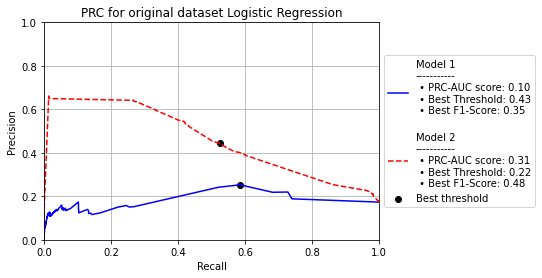

In [13]:
lr_best_threshold1, lr_best_threshold2, lr_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "original dataset Logistic Regression")

Best Threshold=0.237948, F1-Score=0.499 for model 1
Best Threshold=0.239114, F1-Score=0.499 for model 2


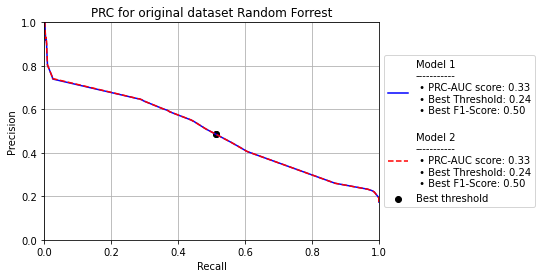

In [14]:
rf_best_threshold1, rf_best_threshold2, rf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "original dataset Random Forrest")

Best Threshold=0.235370, F1-Score=0.499 for model 1
Best Threshold=0.258003, F1-Score=0.499 for model 2


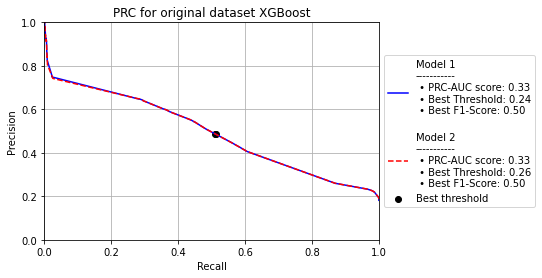

In [15]:
xgb_best_threshold1, xgb_best_threshold2, xgb_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "original dataset XGBoost")

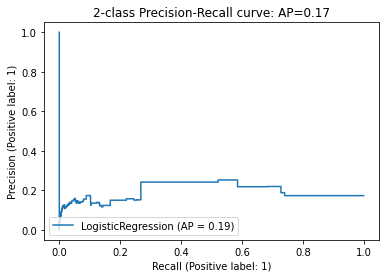

In [16]:
simple_threshold_plot(lr_model1, x1_test, y_test)

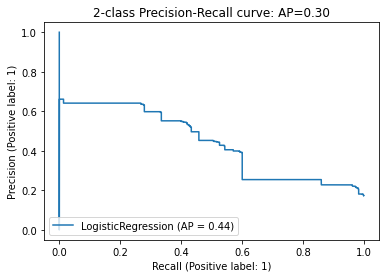

In [17]:
simple_threshold_plot(lr_model2, x2_test, y_test)

Using the best thresholds...

In [18]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)

results_data[3][0] = "Original_Logistic_Regression_Best_Threshold"
results_data[3][1] = lr_model1.score(x1_test, y_test)
results_data[3][2] = lr_model2.score(x2_test, y_test)
results_data[3][3] = acc1
results_data[3][4] = acc2
results_data[3][5] = prc_val1
results_data[3][6] = prc_val2
results_data[3][7] = pr_auc1
results_data[3][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[4][0] = "Original_Random_Forrest_Best_Threshold"
results_data[4][1] = rf_model1.score(x1_test, y_test)
results_data[4][2] = rf_model2.score(x2_test, y_test)
results_data[4][3] = acc1
results_data[4][4] = acc2
results_data[4][5] = prc_val1
results_data[4][6] = prc_val2
results_data[4][7] = pr_auc1
results_data[4][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[5][0] = "Original_XGBoost_Classifier_Best_Threshold"
results_data[5][1] = xgb_model1.score(x1_test, y_test)
results_data[5][2] = xgb_model2.score(x2_test, y_test)
results_data[5][3] = acc1
results_data[5][4] = acc2
results_data[5][5] = prc_val1
results_data[5][6] = prc_val2
results_data[5][7] = pr_auc1
results_data[5][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5571730860503243
Average Precision-Recall Score: 0.1939281481194385
PRC-AUC for model 1: 0.10230392909719606
Accuracy: 0.628
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.64      0.74    127808
           1       0.25      0.59      0.35     26825

    accuracy                           0.63    154633
   macro avg       0.57      0.61      0.55    154633
weighted avg       0.77      0.63      0.67    154633


Scores for model 2
------------------
Roc_Auc Score: 0.7771862787482714
Average Precision-Recall Score: 0.43673794851980996
PRC-AUC for model 2: 0.310643596675861
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.86      0.88    127808
           1       0.44      0.53      0.48     26825

    accuracy                           0.80    154633
   macro avg       0.67      0.69      0.68    154633
weighted

### Cross Validation

In [19]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df['Bug']

In [20]:
print("Cross validation results for model 1")
print("------------------------------------")

cv_results = cross_validate(lr_model1, x1, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

print("\nCross validation results for model 2")
print("------------------------------------")

cv_results = cross_validate(lr_model2, x2, y, cv=3)
sorted(cv_results.keys())
print(cv_results['test_score'])

Cross validation results for model 1
------------------------------------
[0.82727252 0.43001152 0.82727252]

Cross validation results for model 2
------------------------------------
[0.85011117 0.46864051 0.77310929]


#### Model 1 Cross Validation

#### Leave One Out

In [21]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model1, x1, y)

#### Repeated KFold

In [22]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, x1, y)
results_data[6][0] = "Original_Logistic_Regression_rkf"
results_data[6][1] = model_score
results_data[6][3] = acc
results_data[6][5] = prc_val
results_data[6][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, x1, y, lr_best_threshold1)
results_data[7][0] = "Original_Logistic_Regression_rkf_Best_Threshold"
results_data[7][1] = model_score
results_data[7][3] = acc
results_data[7][5] = prc_val
results_data[7][7] = pr_auc

Rkf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, x1, y)
results_data[8][0] = "Original_Random_Forrest_rkf"
results_data[8][1] = model_score
results_data[8][3] = acc
results_data[8][5] = prc_val
results_data[8][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, x1, y)
results_data[9][0] = "Original_XGB_Classifier_rkf"
results_data[9][1] = model_score
results_data[9][3] = acc
results_data[9][5] = prc_val
results_data[9][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 515437 515438 515439] | TEST: [    36     40     42 ... 515435 515440 515441]

Model Score: 0.8228891820580475
Average Precision-Recall Score: 0.17711081794195252
PRC-AUC Score: 0.10554657598160798
Classification Report:

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     42415
           1       0.00      0.00      0.00      9129

    accuracy                           0.82     51544
   macro avg       0.41      0.50      0.45     51544
weighted avg       0.68      0.82      0.74     51544

Accuracy: 0.823
---------------------
With best threshold
TRAIN: [     0      1      2 ... 515437 515438 515439] | TEST: [    36     40     42 ... 515435 515440 515441]

Model Score: 0.8228891820580475
Average Precision-Recall Score: 0.17711081794195252
PRC-AUC Score: 0.3267221896318499
Classific

#### Stratified KFold

In [23]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, x1, y)
results_data[10][0] = "Original_Logistic_Regression_skf"
results_data[10][1] = model_score
results_data[10][3] = acc
results_data[10][5] = prc_val
results_data[10][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, x1, y, lr_best_threshold1)
results_data[11][0] = "Original_Logistic_Regression_skf_Best_Threshold"
results_data[11][1] = model_score
results_data[11][3] = acc
results_data[11][5] = prc_val
results_data[11][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, x1, y)
results_data[12][0] = "Original_Random_Forrest_skf"
results_data[12][1] = model_score
results_data[12][3] = acc
results_data[12][5] = prc_val
results_data[12][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, x1, y)
results_data[13][0] = "Original_XGB_Classifier_skf"
results_data[13][1] = model_score
results_data[13][3] = acc
results_data[13][5] = prc_val
results_data[13][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 515439 515440 515441] | TEST: [304086 304087 304088 ... 423424 423425 423426]

Model Score: 0.8325896321589322

Average Precision-Recall Score: 0.19818651071425664
PRC-AUC Score: 0.40776339244650334
Classification Report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     42641
           1       1.00      0.03      0.06      8903

    accuracy                           0.83     51544
   macro avg       0.92      0.52      0.48     51544
weighted avg       0.86      0.83      0.76     51544

Accuracy: 0.833
---------------------
With best threshold
TRAIN: [     0      1      2 ... 515439 515440 515441] | TEST: [304086 304087 304088 ... 423424 423425 423426]

Model Score: 0.8325896321589322

Average Precision-Recall Score: 0.19818651071425664
PRC-AUC Score: 0.569075517942594
Classifi

#### Time Series Split

In [24]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, x1, y)
results_data[14][0] = "Original_Logistic_Regression_tss"
results_data[14][1] = model_score
results_data[14][3] = acc
results_data[14][5] = prc_val
results_data[14][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, x1, y, lr_best_threshold1)
results_data[15][0] = "Original_Logistic_Regression_tss_Best_Threshold"
results_data[15][1] = model_score
results_data[15][3] = acc
results_data[15][5] = prc_val
results_data[15][7] = pr_auc

Skf_short(lr_model1, x1, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, x1, y)
results_data[16][0] = "Original_Random_Forrest_tss"
results_data[16][1] = model_score
results_data[16][3] = acc
results_data[16][5] = prc_val
results_data[16][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, x1, y)
results_data[17][0] = "Original_XGB_Classifier_tss"
results_data[17][1] = model_score
results_data[17][3] = acc
results_data[17][5] = prc_val
results_data[17][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 429532 429533 429534] | TEST: [429535 429536 429537 ... 515439 515440 515441]

Model Score: 0.7094183244671564

Average Precision-Recall Score: 0.29058167553284364
PRC-AUC Score: 0.26031402749021454
Classification Report:

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     60944
           1       0.00      0.00      0.00     24963

    accuracy                           0.71     85907
   macro avg       0.35      0.50      0.42     85907
weighted avg       0.50      0.71      0.59     85907

Accuracy: 0.709
---------------------
With best threshold
TRAIN: [     0      1      2 ... 429532 429533 429534] | TEST: [429535 429536 429537 ... 515439 515440 515441]

Model Score: 0.7094183244671564

Average Precision-Recall Score: 0.29058167553284364
PRC-AUC Score: 0.5958002395840389
Classif

#### Model 2 Cross Validation

#### Leave One Out

In [25]:
# NOTE: Running extremely slow, working on this issue
#Loo(lr_model2, x2, y)

#### Repeated KFold

In [26]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, x2, y)
results_data[6][2] = model_score
results_data[6][4] = acc
results_data[6][6] = prc_val
results_data[6][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, x2, y, lr_best_threshold2)
results_data[7][2] = model_score
results_data[7][4] = acc
results_data[7][6] = prc_val
results_data[7][8] = pr_auc

Rkf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, x2, y)
results_data[8][2] = model_score
results_data[8][4] = acc
results_data[8][6] = prc_val
results_data[8][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, x2, y)
results_data[9][2] = model_score
results_data[9][4] = acc
results_data[9][6] = prc_val
results_data[9][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 515439 515440 515441] | TEST: [     3     14     23 ... 515426 515435 515438]

Model Score: 0.8475283253142946
Average Precision-Recall Score: 0.30594454701102547
PRC-AUC Score: 0.32154173547811077
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42561
           1       0.64      0.28      0.39      8983

    accuracy                           0.85     51544
   macro avg       0.75      0.62      0.65     51544
weighted avg       0.83      0.85      0.82     51544

Accuracy: 0.848
---------------------
With best threshold
TRAIN: [     0      1      2 ... 515439 515440 515441] | TEST: [     3     14     23 ... 515426 515435 515438]

Model Score: 0.8475283253142946
Average Precision-Recall Score: 0.30594454701102547
PRC-AUC Score: 0.3801916167310715
Classific

#### Stratified KFold

In [27]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, x2, y)
results_data[10][2] = model_score
results_data[10][4] = acc
results_data[10][6] = prc_val
results_data[10][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, x2, y, lr_best_threshold2)
results_data[11][2] = model_score
results_data[11][4] = acc
results_data[11][6] = prc_val
results_data[11][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, x2, y)
results_data[12][2] = model_score
results_data[12][4] = acc
results_data[12][6] = prc_val
results_data[12][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, x2, y)
results_data[13][2] = model_score
results_data[13][4] = acc
results_data[13][6] = prc_val
results_data[13][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 515439 515440 515441] | TEST: [194011 194012 194013 ... 296081 296082 296083]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42641
           1       1.00      1.00      1.00      8903

    accuracy                           1.00     51544
   macro avg       1.00      1.00      1.00     51544
weighted avg       1.00      1.00      1.00     51544

Accuracy: 1.000
---------------------
With best threshold
TRAIN: [     0      1      2 ... 515439 515440 515441] | TEST: [194011 194012 194013 ... 296081 296082 296083]

Model Score: 1.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       1.

#### Time Series Split

In [28]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, x2, y)
results_data[14][2] = model_score
results_data[14][4] = acc
results_data[14][6] = prc_val
results_data[14][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, x2, y, lr_best_threshold2)
results_data[15][2] = model_score
results_data[15][4] = acc
results_data[15][6] = prc_val
results_data[15][8] = pr_auc

Skf_short(lr_model2, x2, y)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, x2, y)
results_data[16][2] = model_score
results_data[16][4] = acc
results_data[16][6] = prc_val
results_data[16][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, x2, y)
results_data[17][2] = model_score
results_data[17][4] = acc
results_data[17][6] = prc_val
results_data[17][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 429532 429533 429534] | TEST: [429535 429536 429537 ... 515439 515440 515441]

Model Score: 0.70040858137288

Average Precision-Recall Score: 0.2896312281676218
PRC-AUC Score: 0.28591528072527095
Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.98      0.82     60944
           1       0.19      0.01      0.02     24963

    accuracy                           0.70     85907
   macro avg       0.45      0.50      0.42     85907
weighted avg       0.56      0.70      0.59     85907

Accuracy: 0.700
---------------------
With best threshold
TRAIN: [     0      1      2 ... 429532 429533 429534] | TEST: [429535 429536 429537 ... 515439 515440 515441]

Model Score: 0.70040858137288

Average Precision-Recall Score: 0.2896312281676218
PRC-AUC Score: 0.49726728652733376
Classificati

Best Threshold=0.429315, F1-Score=0.358 for model 1
Best Threshold=0.208981, F1-Score=0.487 for model 2


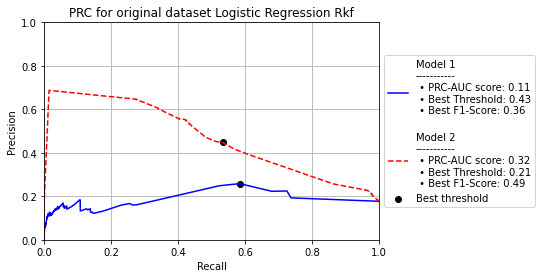

Best Threshold=0.234970, F1-Score=0.507 for model 1
Best Threshold=0.234603, F1-Score=0.507 for model 2


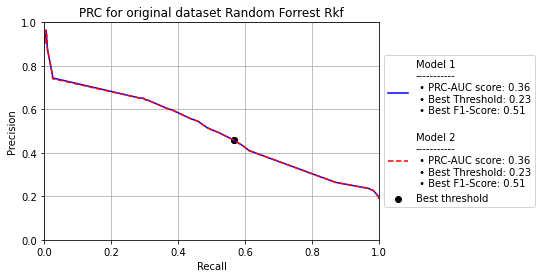

Best Threshold=0.257164, F1-Score=0.507 for model 1
Best Threshold=0.234756, F1-Score=0.507 for model 2


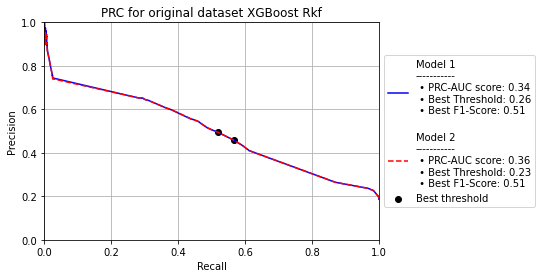

Best Threshold=0.419811, F1-Score=0.295 for model 1
Best Threshold=0.505392, F1-Score=1.000 for model 2


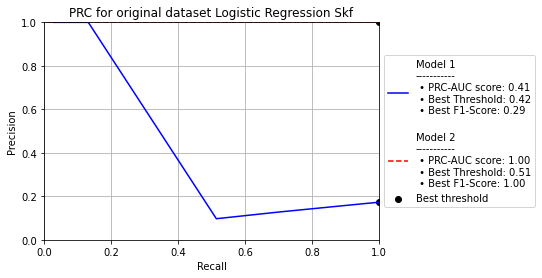

Best Threshold=0.513213, F1-Score=1.000 for model 1
Best Threshold=0.513646, F1-Score=1.000 for model 2


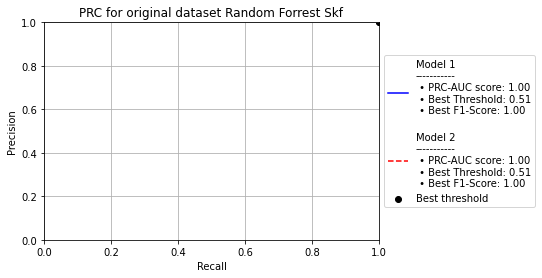

Best Threshold=0.513260, F1-Score=1.000 for model 1
Best Threshold=0.513372, F1-Score=1.000 for model 2


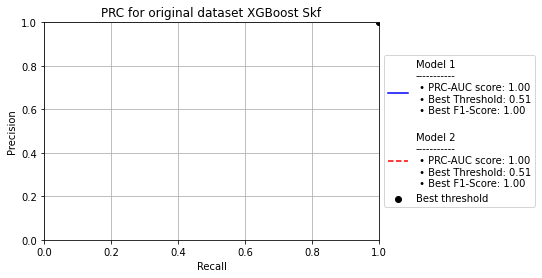

Best Threshold=0.379569, F1-Score=0.450 for model 1
Best Threshold=0.059407, F1-Score=0.464 for model 2


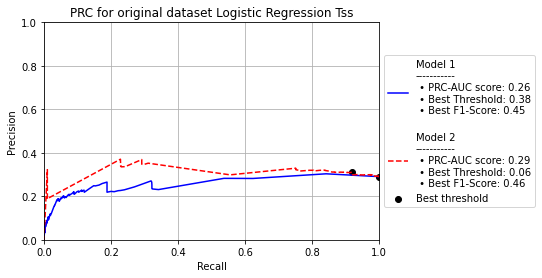

Best Threshold=0.006590, F1-Score=0.467 for model 1
Best Threshold=0.086622, F1-Score=0.478 for model 2


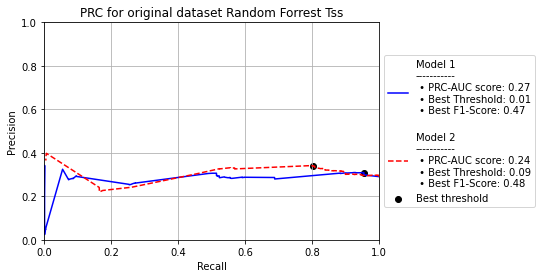

Best Threshold=0.004674, F1-Score=0.460 for model 1
Best Threshold=0.000229, F1-Score=0.462 for model 2


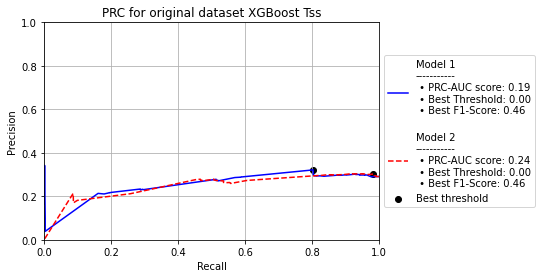

In [29]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "original dataset Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "original dataset Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "original dataset XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "original dataset Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "original dataset Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "original dataset XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_og_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "original dataset Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_og_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "original dataset Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_og_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "original dataset XGBoost Tss")

### Rebalancing data

#### Undersampling

In [30]:
bug_df = graph_df.loc[graph_df['Bug'] == 1].sample(n=1900, random_state=42)
non_bug_df = graph_df.loc[graph_df['Bug'] == 0].sample(n=1900, random_state=42)
normalized_under_df = pd.concat([bug_df, non_bug_df])
normalized_under_df = normalized_under_df.reset_index()
print(normalized_under_df['Bug'].value_counts())

usx1 = normalized_under_df[labels1]
usx2 = normalized_under_df[labels2]
usy = normalized_under_df["Bug"]
usy = usy.sample(frac=1).reset_index(drop=True) # shuffle dataset

train, test = train_test_split(normalized_under_df, test_size=0.3, random_state = 5)

labels1 = ['PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree']
labels2 = set(list(normalized_under_df.columns))
labels2.difference_update(['index', 'Bug', 'Name', 'File', 'PageRank', 'Betweenness', 'Closeness', 'Harmonic', 'Degree'])

x1_train = train[labels1]
x2_train = train[labels2]
y_train = train["Bug"]
x1_test = test[labels1]
x2_test = test[labels2]
y_test = test["Bug"]

0    1900
1    1900
Name: Bug, dtype: int64


In [31]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [32]:
lr_model1.fit(x1_train, y_train)
lr_model2.fit(x2_train, y_train)
rf_model1.fit(x1_train, y_train)
rf_model2.fit(x2_train, y_train)
xgb_model1.fit(x1_train, y_train)
xgb_model2.fit(x2_train, y_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y_test)}")
results_data[18][0] = "Undersampled_Logistic_Regression"
results_data[18][1] = lr_model1.score(x1_test, y_test)
results_data[18][2] = lr_model2.score(x2_test, y_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y_test)}")
results_data[19][0] = "Undersampled_Random_Forrest"
results_data[19][1] = rf_model1.score(x1_test, y_test)
results_data[19][2] = rf_model2.score(x2_test, y_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y_test)}")
results_data[20][0] = "Undersampled_XGB_Classifier"
results_data[20][1] = xgb_model1.score(x1_test, y_test)
results_data[20][2] = xgb_model2.score(x2_test, y_test)

Logistic regression training score for model 1: 0.5456140350877193
Logistic regression training score for model 2: 0.7087719298245614
Random Forrest Classification training score for model 1: 0.7149122807017544
Random Forrest Classification training score for model 2: 0.7131578947368421
XGB Classifier training score for model 1: 0.712280701754386
XGB Classifier training score for model 2: 0.7140350877192982


In [33]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[18][3] = acc1
results_data[18][4] = acc2
results_data[18][5] = prc_val1
results_data[18][6] = prc_val2
results_data[18][7] = pr_auc1
results_data[18][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[19][3] = acc1
results_data[19][4] = acc2
results_data[19][5] = prc_val1
results_data[19][6] = prc_val2
results_data[19][7] = pr_auc1
results_data[19][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[20][3] = acc1
results_data[20][4] = acc2
results_data[20][5] = prc_val1
results_data[20][6] = prc_val2
results_data[20][7] = pr_auc1
results_data[20][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.609921750618204
Average Precision-Recall Score: 0.5645595046010683
PRC-AUC for model 1: 0.5696450646931078
Accuracy: 0.546
Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.72      0.62       583
           1       0.55      0.36      0.44       557

    accuracy                           0.55      1140
   macro avg       0.55      0.54      0.53      1140
weighted avg       0.55      0.55      0.53      1140


Scores for model 2
------------------
Roc_Auc Score: 0.7805537506428397
Average Precision-Recall Score: 0.7352689734152424
PRC-AUC for model 2: 0.7497136638969243
Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       583
           1       0.76      0.59      0.66       557

    accuracy       

###### Compare Precision-Recall thresholds between models for undersampling

Best Threshold=0.374656, F1-Score=0.685 for model 1
Best Threshold=0.409570, F1-Score=0.730 for model 2


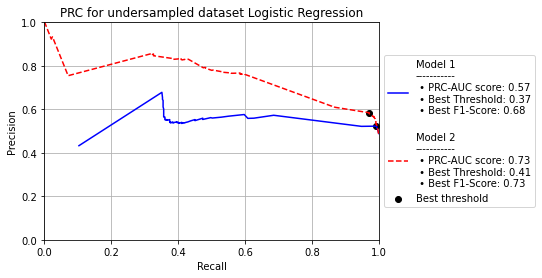

In [34]:
lr_best_threshold1, lr_best_threshold2, lr_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y_test, x2_test, y_test, lr_prediction_probs1, lr_prediction_probs2, "undersampled dataset Logistic Regression")

Best Threshold=0.368644, F1-Score=0.728 for model 1
Best Threshold=0.380106, F1-Score=0.732 for model 2


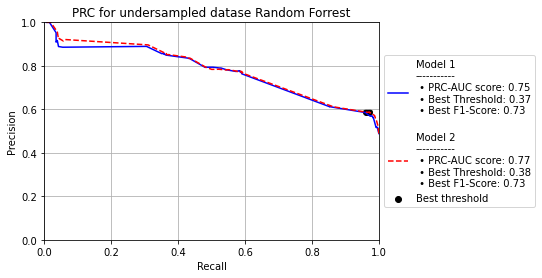

In [35]:
rf_best_threshold1, rf_best_threshold2, rf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y_test, x2_test, y_test, rf_prediction_probs1, rf_prediction_probs2, "undersampled datase Random Forrest")

Best Threshold=0.411515, F1-Score=0.726 for model 1
Best Threshold=0.411868, F1-Score=0.729 for model 2


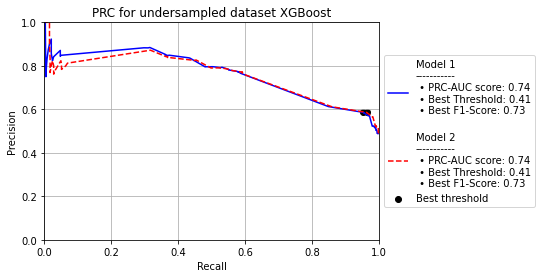

In [36]:
rf_best_threshold1, rf_best_threshold2, xgb_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y_test, x2_test, y_test, xgb_prediction_probs1, xgb_prediction_probs2, "undersampled dataset XGBoost")

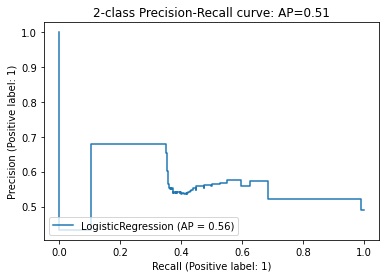

In [37]:
simple_threshold_plot(lr_model1, x1_test, y_test)

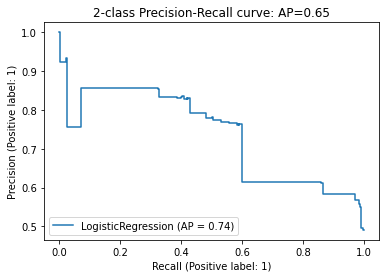

In [38]:
simple_threshold_plot(lr_model2, x2_test, y_test)

In [39]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[21][0] = "Undersampled_Logistic_Regression_Best_Threshold"
results_data[21][1] = lr_model1.score(x1_test, y_test)
results_data[21][2] = lr_model2.score(x2_test, y_test)
results_data[21][3] = acc1
results_data[21][4] = acc2
results_data[21][5] = prc_val1
results_data[21][6] = prc_val2
results_data[21][7] = pr_auc1
results_data[21][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[22][0] = "Undersampled_Random_Forrest_Best_Threshold"
results_data[22][1] = rf_model1.score(x1_test, y_test)
results_data[22][2] = rf_model2.score(x2_test, y_test)
results_data[22][3] = acc1
results_data[22][4] = acc2
results_data[22][5] = prc_val1
results_data[22][6] = prc_val2
results_data[22][7] = pr_auc1
results_data[22][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[23][0] = "Undersampled_XGB_Classifier_Best_Threshold"
results_data[23][1] = xgb_model1.score(x1_test, y_test)
results_data[23][2] = xgb_model2.score(x2_test, y_test)
results_data[23][3] = acc1
results_data[23][4] = acc2
results_data[23][5] = prc_val1
results_data[23][6] = prc_val2
results_data[23][7] = pr_auc1
results_data[23][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.609921750618204
Average Precision-Recall Score: 0.5645595046010683
PRC-AUC for model 1: 0.5660138948502103
Accuracy: 0.554
Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.13      0.23       583
           1       0.52      0.99      0.68       557

    accuracy                           0.55      1140
   macro avg       0.74      0.56      0.46      1140
weighted avg       0.74      0.55      0.45      1140


Scores for model 2
------------------
Roc_Auc Score: 0.7805537506428397
Average Precision-Recall Score: 0.7352689734152424
PRC-AUC for model 2: 0.7338890680494459
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.34      0.50       583
           1       0.58      0.97      0.73       557

    accuracy                           0.65      1140
   macro avg       0.75      0.66      0.61      1140
weighted a

##### Cross Validation After Undersampling Rebalance for model 1

###### Repeated KFold

In [40]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, usx1, usy)
results_data[24][0] = "Undersampled_Logistic_Regression_rkf"
results_data[24][1] = model_score
results_data[24][3] = acc
results_data[24][5] = prc_val
results_data[24][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[25][0] = "Undersampled_Logistic_Regression_rkf_Best_Threshold"
results_data[25][1] = model_score
results_data[25][3] = acc
results_data[25][5] = prc_val
results_data[25][7] = pr_auc

Rkf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, usx1, usy)
results_data[26][0] = "Undersampled_Random_Forrest_rkf"
results_data[26][1] = model_score
results_data[26][3] = acc
results_data[26][5] = prc_val
results_data[26][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, usx1, usy)
results_data[27][0] = "Undersampled_XGB_Classifier_rkf"
results_data[27][1] = model_score
results_data[27][3] = acc
results_data[27][5] = prc_val
results_data[27][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   1    2    3 ... 3797 3798 3799] | TEST: [   0    8   14   20   27   34   66   84   88  100  107  121  126  133
  145  154  171  188  190  196  198  208  213  221  231  246  248  254
  256  258  264  265  267  286  291  296  322  339  342  343  346  363
  373  376  377  415  418  432  441  478  501  502  512  532  539  548
  549  550  556  562  571  591  597  604  616  620  622  672  681  701
  704  722  726  729  734  747  749  755  769  771  793  798  812  813
  819  833  838  849  872  889  904  914  918  921  936  937  938  948
  953  955 1019 1020 1031 1033 1039 1054 1058 1060 1076 1079 1089 1090
 1097 1108 1115 1118 1124 1137 1140 1149 1153 1158 1160 1178 1181 1195
 1201 1208 1210 1219 1226 1274 1297 1317 1330 1342 1352 1353 1365 1372
 1375 1382 1385 1388 1399 1412 1419 1426 1436 1442 1446 1480 1483 1495
 1514 1535 1547 1548 1559 1565 1566 1570 1588 1

In [41]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, usx1, usy)
results_data[28][0] = "Undersampled_Logistic_Regression_skf"
results_data[28][1] = model_score
results_data[28][3] = acc
results_data[28][5] = prc_val
results_data[28][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, usx1, usy, lr_best_threshold1)
results_data[29][0] = "Undersampled_Logistic_Regression_skf_Best_Threshold"
results_data[29][1] = model_score
results_data[29][3] = acc
results_data[29][5] = prc_val
results_data[29][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, usx1, usy)
results_data[30][0] = "Undersampled_Random_Forrest_skf"
results_data[30][1] = model_score
results_data[30][3] = acc
results_data[30][5] = prc_val
results_data[30][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, usx1, usy)
results_data[31][0] = "Undersampled_XGB_Classifier_skf"
results_data[31][1] = model_score
results_data[31][3] = acc
results_data[31][5] = prc_val
results_data[31][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [365 368 369 371 373 376 378 381 383 384 386 387 388 389 390 391 392 393
 395 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433
 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487
 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505
 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523
 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541
 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559
 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577
 578 579 580 581 582 583 

In [42]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, usx1, usy)
results_data[32][0] = "Undersampled_Logistic_Regression_tss"
results_data[32][1] = model_score
results_data[32][3] = acc
results_data[32][5] = prc_val
results_data[32][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, usx1, usy, lr_best_threshold1)
results_data[33][0] = "Undersampled_Logistic_Regression_tss_Best_Threshold"
results_data[33][1] = model_score
results_data[33][3] = acc
results_data[33][5] = prc_val
results_data[33][7] = pr_auc

Skf_short(lr_model1, usx1, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, usx1, usy)
results_data[34][0] = "Undersampled_Random_Forrest_tss"
results_data[34][1] = model_score
results_data[34][3] = acc
results_data[34][5] = prc_val
results_data[34][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, usx1, usy)
results_data[35][0] = "Undersampled_XGB_Classifier_tss"
results_data[35][1] = model_score
results_data[35][3] = acc
results_data[35][5] = prc_val
results_data[35][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 1265 1266 1267] | TEST: [1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281
 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295
 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308 1309
 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323
 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337
 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351
 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365
 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379
 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393
 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407
 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1

TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334
 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348
 3349 3350 3351 3352 3353 

##### Cross Validation After Undersampling Rebalance for model 2

In [43]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, usx2, usy)
results_data[24][2] = model_score
results_data[24][4] = acc
results_data[24][6] = prc_val
results_data[24][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[25][2] = model_score
results_data[25][4] = acc
results_data[25][6] = prc_val
results_data[25][8] = pr_auc

Rkf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, usx2, usy)
results_data[26][2] = model_score
results_data[26][4] = acc
results_data[26][6] = prc_val
results_data[26][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, usx2, usy)
results_data[27][2] = model_score
results_data[27][4] = acc
results_data[27][6] = prc_val
results_data[27][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [  18   49   65   84   85   99  113  118  128  132  140  150  151  155
  185  230  269  275  281  286  290  297  300  303  304  307  323  342
  344  349  360  374  380  383  406  426  482  489  493  494  497  503
  529  530  575  584  604  607  618  619  629  636  643  664  668  669
  687  690  714  719  731  743  751  782  786  788  821  836  841  843
  856  858  865  866  890  891  910  916  931  939  941  958  961  968
  986 1000 1004 1009 1014 1024 1033 1058 1072 1088 1099 1125 1142 1177
 1179 1186 1190 1195 1198 1207 1208 1216 1225 1229 1239 1241 1244 1249
 1260 1264 1269 1273 1286 1299 1302 1307 1310 1316 1317 1321 1323 1326
 1357 1359 1364 1368 1374 1381 1385 1399 1404 1405 1437 1441 1447 1451
 1462 1472 1475 1477 1505 1525 1535 1543 1575 1587 1600 1608 1616 1624
 1626 1628 1637 1655 1665 1667 1671 1677 1697 1

In [44]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, usx2, usy)
results_data[28][2] = model_score
results_data[28][4] = acc
results_data[28][6] = prc_val
results_data[28][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, usx2, usy, lr_best_threshold2)
results_data[29][2] = model_score
results_data[29][4] = acc
results_data[29][6] = prc_val
results_data[29][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, usx2, usy)
results_data[30][2] = model_score
results_data[30][4] = acc
results_data[30][6] = prc_val
results_data[30][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, usx2, usy)
results_data[31][2] = model_score
results_data[31][4] = acc
results_data[31][6] = prc_val
results_data[31][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3797 3798 3799] | TEST: [1497 1500 1501 1502 1505 1510 1514 1517 1520 1522 1523 1524 1527 1528
 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547
 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561
 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575
 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589
 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603
 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617
 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631
 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645
 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659
 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673
 1674 1675 1676 1677 1678 1679 1680 1681 1682 1

In [45]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, usx2, usy)
results_data[32][2] = model_score
results_data[32][4] = acc
results_data[32][6] = prc_val
results_data[32][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, usx2, usy, lr_best_threshold2)
results_data[33][2] = model_score
results_data[33][4] = acc
results_data[33][6] = prc_val
results_data[33][8] = pr_auc

Skf_short(lr_model2, usx2, usy)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, usx2, usy)
results_data[34][2] = model_score
results_data[34][4] = acc
results_data[34][6] = prc_val
results_data[34][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, usx2, usy)
results_data[35][2] = model_score
results_data[35][4] = acc
results_data[35][6] = prc_val
results_data[35][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3

TRAIN: [   0    1    2 ... 3164 3165 3166] | TEST: [3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196 3197 3198 3199 3200 3201 3202 3203 3204 3205 3206 3207 3208
 3209 3210 3211 3212 3213 3214 3215 3216 3217 3218 3219 3220 3221 3222
 3223 3224 3225 3226 3227 3228 3229 3230 3231 3232 3233 3234 3235 3236
 3237 3238 3239 3240 3241 3242 3243 3244 3245 3246 3247 3248 3249 3250
 3251 3252 3253 3254 3255 3256 3257 3258 3259 3260 3261 3262 3263 3264
 3265 3266 3267 3268 3269 3270 3271 3272 3273 3274 3275 3276 3277 3278
 3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292
 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306
 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320
 3321 3322 3323 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334
 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348
 3349 3350 3351 3352 3353 

Best Threshold=0.467424, F1-Score=0.707 for model 1
Best Threshold=0.360740, F1-Score=0.692 for model 2


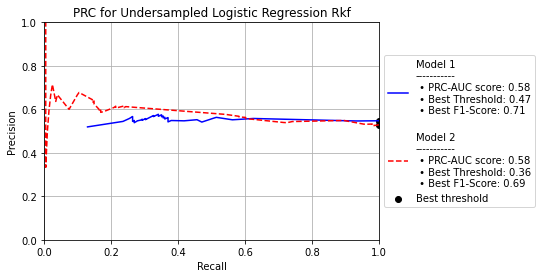

Best Threshold=0.238085, F1-Score=0.701 for model 1
Best Threshold=0.018576, F1-Score=0.693 for model 2


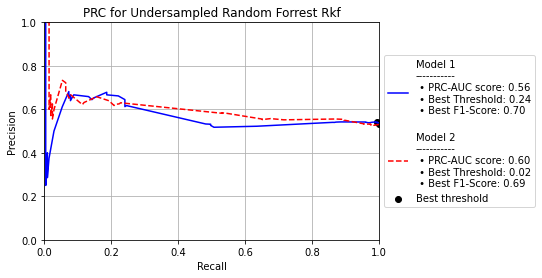

Best Threshold=0.030594, F1-Score=0.710 for model 1
Best Threshold=0.004401, F1-Score=0.692 for model 2


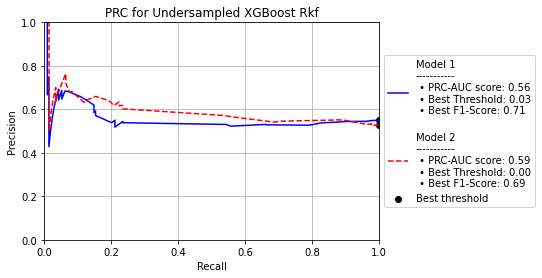

Best Threshold=0.471857, F1-Score=0.667 for model 1
Best Threshold=0.426501, F1-Score=0.669 for model 2


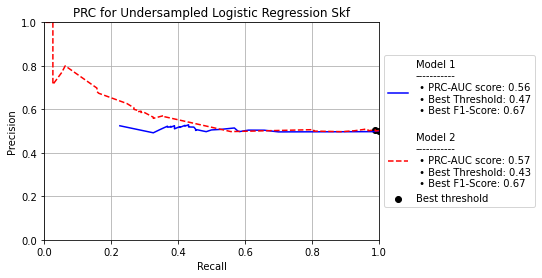

Best Threshold=0.139983, F1-Score=0.670 for model 1
Best Threshold=0.143487, F1-Score=0.669 for model 2


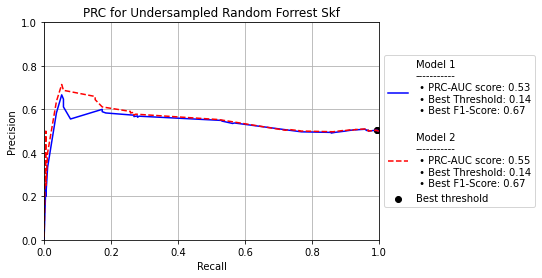

Best Threshold=0.135992, F1-Score=0.670 for model 1
Best Threshold=0.038839, F1-Score=0.668 for model 2


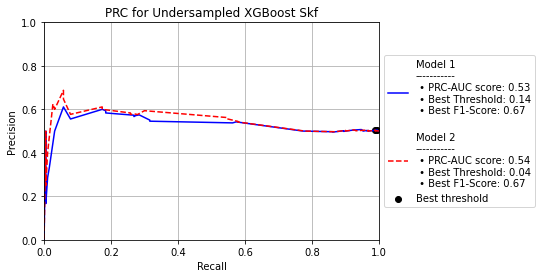

Best Threshold=0.483638, F1-Score=0.665 for model 1
Best Threshold=0.380137, F1-Score=0.680 for model 2


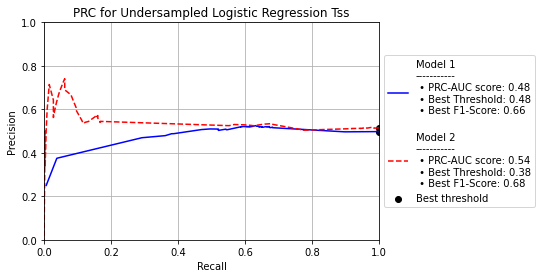

Best Threshold=0.174306, F1-Score=0.679 for model 1
Best Threshold=0.151981, F1-Score=0.679 for model 2


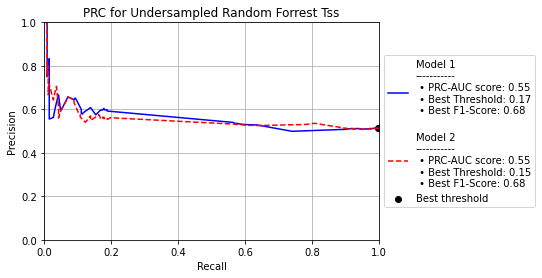

Best Threshold=0.017105, F1-Score=0.679 for model 1
Best Threshold=0.015824, F1-Score=0.679 for model 2


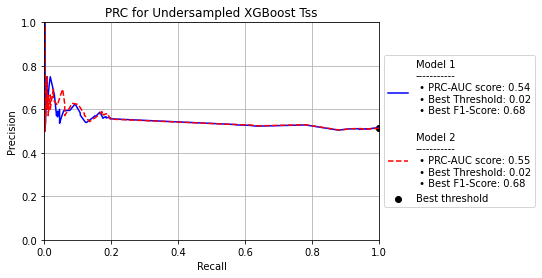

In [46]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Undersampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Undersampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Undersampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Undersampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Undersampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Undersampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_us_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Undersampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_us_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Undersampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_us_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Undersampled XGBoost Tss")

#### Oversampling

In [47]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [48]:
# For oversampling we will use SMOTE (Synthetic Minority Over-sampling Technique)

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

print("x1 Before SMOTE:")

print(x1_train.shape)

print("x2 Before SMOTE:")

print(x2_train.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")

print(oversampled_X1.shape)

print("x2 After SMOTE:")

print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(2660, 5)
x2 Before SMOTE:
(2660, 129)
x1 After SMOTE:
(852822, 5)
x2 After SMOTE:
(852822, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [49]:
x1_train, x1_test, y1_train, y1_test = train_test_split(osx1, osy1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(osx2, osy2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[36][0] = "Oversampled_Logistic_Regression"
results_data[36][1] = lr_model1.score(x1_test, y1_test)
results_data[36][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[37][0] = "Oversampled_Random_Forrest"
results_data[37][1] = rf_model1.score(x1_test, y1_test)
results_data[37][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[38][0] = "Oversampled_XGB_Classifier"
results_data[38][1] = xgb_model1.score(x1_test, y1_test)
results_data[38][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5378487924423582
Logistic regression training score for model 2: 0.704776682939413
Random Forrest Classification training score for model 1: 0.708892423987774
Random Forrest Classification training score for model 2: 0.7089002411597556
XGB Classifier training score for model 1: 0.7090370416694353
XGB Classifier training score for model 2: 0.7088846068157922


In [50]:
y1_train = y1_train.astype('int')
y1_test = y1_test.astype('int')
y2_train = y2_train.astype('int')
y2_test = y2_test.astype('int')

In [51]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[36][3] = acc1
results_data[36][4] = acc2
results_data[36][5] = prc_val1
results_data[36][6] = prc_val2
results_data[36][7] = pr_auc1
results_data[36][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[37][3] = acc1
results_data[37][4] = acc2
results_data[37][5] = prc_val1
results_data[37][6] = prc_val2
results_data[37][7] = pr_auc1
results_data[37][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[38][3] = acc1
results_data[38][4] = acc2
results_data[38][5] = prc_val1
results_data[38][6] = prc_val2
results_data[38][7] = pr_auc1
results_data[38][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5864805061987381
Average Precision-Recall Score: 0.5566448391919663
PRC-AUC for model 1: 0.5585121311047823
Accuracy: 0.538
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.71      0.61    128063
           1       0.56      0.37      0.44    127784

    accuracy                           0.54    255847
   macro avg       0.54      0.54      0.52    255847
weighted avg       0.54      0.54      0.52    255847


Scores for model 2
------------------
Roc_Auc Score: 0.7823191685116807
Average Precision-Recall Score: 0.7550563429168903
PRC-AUC for model 2: 0.7707929286453185
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.73    128063
           1       0.76      0.60      0.67    127784

    accuracy      

In [52]:
y1_test.value_counts()

0    128063
1    127784
Name: Bug, dtype: int64

###### Compare Precision-Recall thresholds between models for oversampling

Best Threshold=0.367050, F1-Score=0.689 for model 1
Best Threshold=0.333753, F1-Score=0.730 for model 2


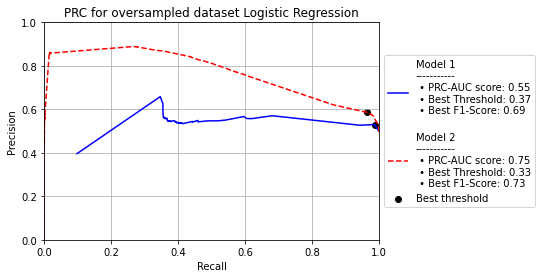

In [53]:
lr_best_threshold1, lr_best_threshold2, lr_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "oversampled dataset Logistic Regression")

Best Threshold=0.291169, F1-Score=0.732 for model 1
Best Threshold=0.300354, F1-Score=0.732 for model 2


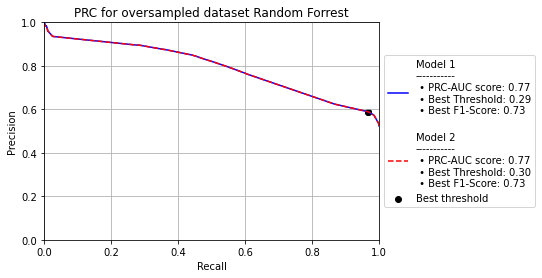

In [54]:
rf_best_threshold1, rf_best_threshold2, rf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "oversampled dataset Random Forrest")

Best Threshold=0.268109, F1-Score=0.732 for model 1
Best Threshold=0.313011, F1-Score=0.732 for model 2


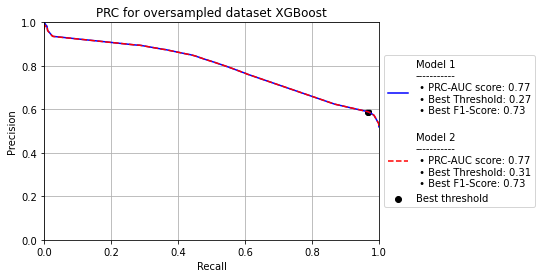

In [55]:
xgb_best_threshold1, xgb_best_threshold2, xgb_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "oversampled dataset XGBoost")

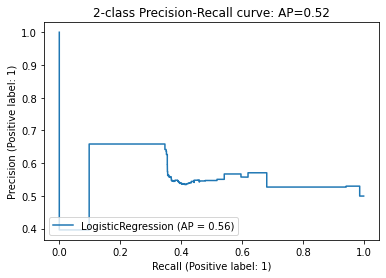

In [56]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

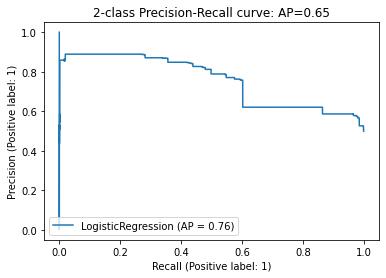

In [57]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using best threshold...

In [58]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[39][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[39][1] = lr_model1.score(x1_test, y1_test)
results_data[39][2] = lr_model2.score(x2_test, y2_test)
results_data[39][3] = acc1
results_data[39][4] = acc2
results_data[39][5] = prc_val1
results_data[39][6] = prc_val2
results_data[39][7] = pr_auc1
results_data[39][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[40][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[40][1] = rf_model1.score(x1_test, y1_test)
results_data[40][2] = rf_model2.score(x2_test, y2_test)
results_data[40][3] = acc1
results_data[40][4] = acc2
results_data[40][5] = prc_val1
results_data[40][6] = prc_val2
results_data[40][7] = pr_auc1
results_data[40][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[41][0] = "Oversampled_Logistic_Regression_Best_Threshold"
results_data[41][1] = xgb_model1.score(x1_test, y1_test)
results_data[41][2] = xgb_model2.score(x2_test, y2_test)
results_data[41][3] = acc1
results_data[41][4] = acc2
results_data[41][5] = prc_val1
results_data[41][6] = prc_val2
results_data[41][7] = pr_auc1
results_data[41][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5864805061987381
Average Precision-Recall Score: 0.5566448391919663
PRC-AUC for model 1: 0.5518069841126853
Accuracy: 0.556
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.13      0.22    128063
           1       0.53      0.99      0.69    127784

    accuracy                           0.56    255847
   macro avg       0.72      0.56      0.46    255847
weighted avg       0.72      0.56      0.45    255847


Scores for model 2
------------------
Roc_Auc Score: 0.7823191685116807
Average Precision-Recall Score: 0.7550563429168903
PRC-AUC for model 2: 0.7513817756707124
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.32      0.47    128063
           1       0.59      0.97      0.73    127784

    accuracy                           0.64    255847
   macro avg       0.74      0.64      0.60    255847
weighted 

##### Cross Validation After Oversampling Rebalance for model 1

In [59]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, osx1, osy1)
results_data[42][0] = "Oversampled_Logistic_Regression_rkf"
results_data[42][1] = model_score
results_data[42][3] = acc
results_data[42][5] = prc_val
results_data[42][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[43][0] = "Oversampled_Logistic_Regression_rkf_Best_Threshold"
results_data[43][1] = model_score
results_data[43][3] = acc
results_data[43][5] = prc_val
results_data[43][7] = pr_auc

Rkf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, osx1, osy1)
results_data[44][0] = "Oversampled_Random_Forrest_rkf"
results_data[44][1] = model_score
results_data[44][3] = acc
results_data[44][5] = prc_val
results_data[44][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, osx1, osy1)
results_data[45][0] = "Oversampled_XGB_Classifier_rkf"
results_data[45][1] = model_score
results_data[45][3] = acc
results_data[45][5] = prc_val
results_data[45][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     1      2      3 ... 852818 852819 852821] | TEST: [     0      6     32 ... 852807 852809 852820]

Model Score: 0.5371004432353838
Average Precision-Recall Score: 0.5260243693410853
PRC-AUC Score: 0.5567458943250518
Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.70      0.60     42256
           1       0.56      0.37      0.45     43026

    accuracy                           0.54     85282
   macro avg       0.54      0.54      0.52     85282
weighted avg       0.54      0.54      0.52     85282

Accuracy: 0.537
---------------------
With best threshold
TRAIN: [     1      2      3 ... 852818 852819 852821] | TEST: [     0      6     32 ... 852807 852809 852820]

Model Score: 0.5371004432353838
Average Precision-Recall Score: 0.5260243693410853
PRC-AUC Score: 0.7575038183195965
Classificati

In [60]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, osx1, osy1)
results_data[46][0] = "Oversampled_Logistic_Regression_skf"
results_data[46][1] = model_score
results_data[46][3] = acc
results_data[46][5] = prc_val
results_data[46][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[47][0] = "Oversampled_Logistic_Regression_skf_Best_Threshold"
results_data[47][1] = model_score
results_data[47][3] = acc
results_data[47][5] = prc_val
results_data[47][7] = pr_auc

Skf_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, osx1, osy1)
results_data[48][0] = "Oversampled_Random_Forrest_skf"
results_data[48][1] = model_score
results_data[48][3] = acc
results_data[48][5] = prc_val
results_data[48][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, osx1, osy1)
results_data[49][0] = "Oversampled_XGB_Classifier_skf"
results_data[49][1] = model_score
results_data[49][3] = acc
results_data[49][5] = prc_val
results_data[49][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [ 43100  43101  43102 ... 509271 509272 509273]

Model Score: 0.6884607717833566

Average Precision-Recall Score: 0.6884680777077554
PRC-AUC Score: 0.6651612265229044
Classification Report:

              precision    recall  f1-score   support

           0       0.62      1.00      0.76     42641
           1       1.00      0.38      0.55     42642

    accuracy                           0.69     85283
   macro avg       0.81      0.69      0.65     85283
weighted avg       0.81      0.69      0.65     85283

Accuracy: 0.688
---------------------
With best threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [ 43100  43101  43102 ... 509271 509272 509273]

Model Score: 0.6884607717833566

Average Precision-Recall Score: 0.6884680777077554
PRC-AUC Score: 0.7500029314165777
Classifica

In [61]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, osx1, osy1)
results_data[50][0] = "Oversampled_Logistic_Regression_tss"
results_data[50][1] = model_score
results_data[50][3] = acc
results_data[50][5] = prc_val
results_data[50][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, osx1, osy1, lr_best_threshold1)
results_data[51][0] = "Oversampled_Logistic_Regression_tss_Best_Threshold"
results_data[51][1] = model_score
results_data[51][3] = acc
results_data[51][5] = prc_val
results_data[51][7] = pr_auc

Tss_short(lr_model1, osx1, osy1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Tss(rf_model1, osx1, osy1)
results_data[52][0] = "Oversampled_Random_Forrest_tss"
results_data[52][1] = model_score
results_data[52][3] = acc
results_data[52][5] = prc_val
results_data[52][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, osx1, osy1)
results_data[53][0] = "Oversampled_XGB_Classifier_tss"
results_data[53][1] = model_score
results_data[53][3] = acc
results_data[53][5] = prc_val
results_data[53][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 568545 568546 568547] | TEST: [568548 568549 568550 ... 710682 710683 710684]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999999
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00  142137.0

    accuracy                           0.00  142137.0
   macro avg       0.00      0.00      0.00  142137.0
weighted avg       0.00      0.00      0.00  142137.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [     0      1      2 ... 568545 568546 568547] | TEST: [568548 568549 568550 ... 710682 710683 710684]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

      

##### Cross Validation After Oversampling Rebalance for model 2

In [62]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, osx2, osy2)
results_data[42][2] = model_score
results_data[42][4] = acc
results_data[42][6] = prc_val
results_data[42][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[43][2] = model_score
results_data[43][4] = acc
results_data[43][6] = prc_val
results_data[43][8] = pr_auc

Rkf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, osx2, osy2)
results_data[44][2] = model_score
results_data[44][4] = acc
results_data[44][6] = prc_val
results_data[44][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, osx2, osy2)
results_data[45][2] = model_score
results_data[45][4] = acc
results_data[45][6] = prc_val
results_data[45][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [    99    105    117 ... 852790 852791 852815]

Model Score: 0.7094814849557938
Average Precision-Recall Score: 0.6617690758705286
PRC-AUC Score: 0.7615896597129519
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.74     42485
           1       0.76      0.61      0.68     42797

    accuracy                           0.71     85282
   macro avg       0.72      0.71      0.71     85282
weighted avg       0.72      0.71      0.71     85282

Accuracy: 0.709
---------------------
With best threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [    99    105    117 ... 852790 852791 852815]

Model Score: 0.7094814849557938
Average Precision-Recall Score: 0.6617690758705286
PRC-AUC Score: 0.7671174966484864
Classificati

In [63]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, osx2, osy2)
results_data[46][2] = model_score
results_data[46][4] = acc
results_data[46][6] = prc_val
results_data[46][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[47][2] = model_score
results_data[47][4] = acc
results_data[47][6] = prc_val
results_data[47][8] = pr_auc

Skf_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, osx2, osy2)
results_data[48][2] = model_score
results_data[48][4] = acc
results_data[48][6] = prc_val
results_data[48][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model1, osx1, osy1)
results_data[49][2] = model_score
results_data[49][4] = acc
results_data[49][6] = prc_val
results_data[49][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [128382 128383 128384 ... 596973 596974 596975]

Model Score: 0.7996411904036022

Average Precision-Recall Score: 0.7996411904036022
PRC-AUC Score: 0.888278219960853
Classification Report:

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     42641
           1       1.00      0.60      0.75     42641

    accuracy                           0.80     85282
   macro avg       0.86      0.80      0.79     85282
weighted avg       0.86      0.80      0.79     85282

Accuracy: 0.800
---------------------
With best threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [128382 128383 128384 ... 596973 596974 596975]

Model Score: 0.7996411904036022

Average Precision-Recall Score: 0.7996411904036022
PRC-AUC Score: 0.7897871140321941
Classificat

In [64]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, osx2, osy2)
results_data[50][2] = model_score
results_data[50][4] = acc
results_data[50][6] = prc_val
results_data[50][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, osx2, osy2, lr_best_threshold2)
results_data[51][2] = model_score
results_data[51][4] = acc
results_data[51][6] = prc_val
results_data[51][8] = pr_auc

Tss_short(lr_model2, osx2, osy2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Tss(rf_model2, osx2, osy2)
results_data[52][2] = model_score
results_data[52][4] = acc
results_data[52][6] = prc_val
results_data[52][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, osx2, osy2)
results_data[53][2] = model_score
results_data[53][4] = acc
results_data[53][6] = prc_val
results_data[53][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 568545 568546 568547] | TEST: [568548 568549 568550 ... 710682 710683 710684]

Model Score: 0.33682292436170735

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.34      0.50    142137

    accuracy                           0.34    142137
   macro avg       0.50      0.17      0.25    142137
weighted avg       1.00      0.34      0.50    142137

Accuracy: 0.337
---------------------
With best threshold
TRAIN: [     0      1      2 ... 568545 568546 568547] | TEST: [568548 568549 568550 ... 710682 710683 710684]

Model Score: 0.33682292436170735

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score 

Best Threshold=0.367454, F1-Score=0.694 for model 1
Best Threshold=0.333586, F1-Score=0.732 for model 2


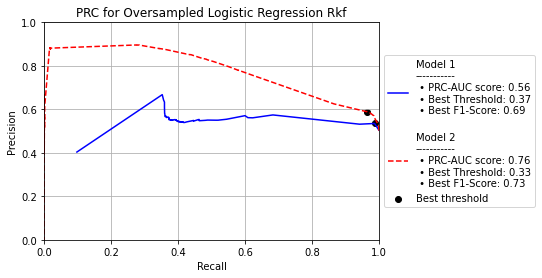

Best Threshold=0.373089, F1-Score=0.735 for model 1
Best Threshold=0.370797, F1-Score=0.735 for model 2


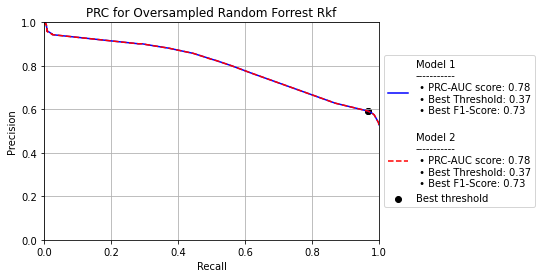

Best Threshold=0.386130, F1-Score=0.735 for model 1
Best Threshold=0.375025, F1-Score=0.735 for model 2


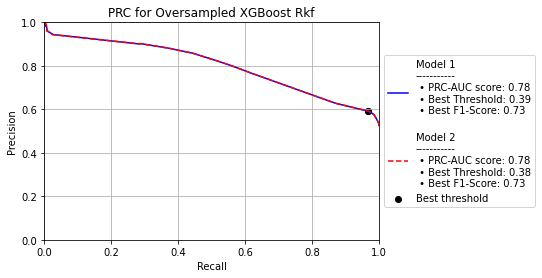

Best Threshold=0.376048, F1-Score=0.667 for model 1
Best Threshold=0.119366, F1-Score=0.778 for model 2


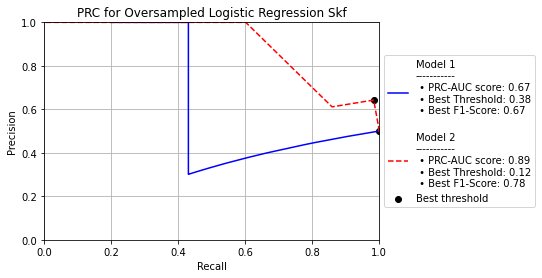

Best Threshold=0.192703, F1-Score=0.775 for model 1
Best Threshold=0.229761, F1-Score=0.773 for model 2


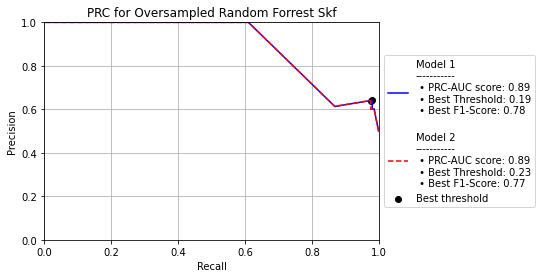

Best Threshold=0.120686, F1-Score=0.778 for model 1
Best Threshold=0.120686, F1-Score=0.778 for model 2


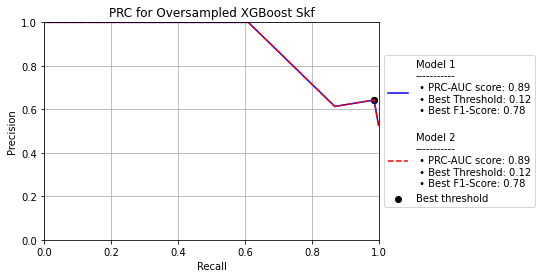

Best Threshold=0.110827, F1-Score=1.000 for model 1
Best Threshold=0.000010, F1-Score=1.000 for model 2


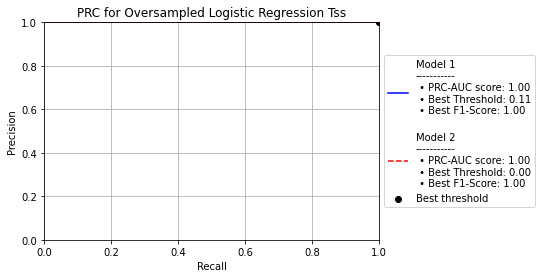

Best Threshold=0.001327, F1-Score=1.000 for model 1
Best Threshold=0.001584, F1-Score=1.000 for model 2


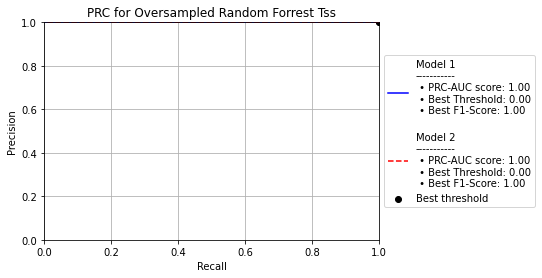

Best Threshold=0.001533, F1-Score=1.000 for model 1
Best Threshold=0.000036, F1-Score=1.000 for model 2


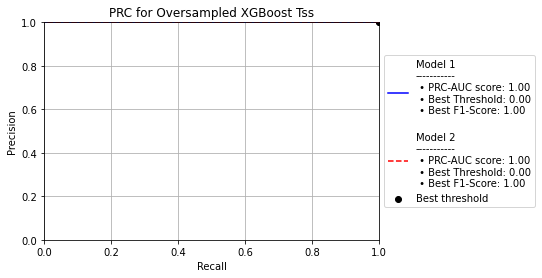

In [65]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "Oversampled Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "Oversampled Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "Oversampled XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "Oversampled Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "Oversampled Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "Oversampled XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_os_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "Oversampled Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_os_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "Oversampled Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_os_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "Oversampled XGBoost Tss")

##### Combining Oversampling with Undersampling

In [66]:
x1 = graph_df[labels1]
x2 = graph_df[labels2]
y = graph_df["Bug"]

In [67]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
print("x1 Before SMOTE:")
print(x1.shape)
print("x2 Before SMOTE:")
print(x2.shape)

# Fit the model to generate the data for Model 1.
oversampled_X1, oversampled_Y1 = sm.fit_resample(x1, y)

# Fit the model to generate the data for Model 2.
oversampled_X2, oversampled_Y2 = sm.fit_resample(x2, y)

print("x1 After SMOTE:")
print(oversampled_X1.shape)
print("x2 After SMOTE:")
print(oversampled_X2.shape)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(oversampled_Y2.value_counts(normalize=True) * 100)

osx1 = oversampled_X1
osx2 = oversampled_X2
osy1 = oversampled_Y1
osy2 = oversampled_Y2

x1 Before SMOTE:
(515442, 5)
x2 Before SMOTE:
(515442, 129)
x1 After SMOTE:
(852822, 5)
x2 After SMOTE:
(852822, 129)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [68]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

print("x1 Before RandomUnderSampler:")
print(osx1.shape)
print("x2 Before RandomUnderSampler:")
print(osx2.shape)

balanced_x1, balanced_y1, = rus.fit_resample(osx1, osy1)
balanced_x2, balanced_y2, = rus.fit_resample(osx2, osy2)

print("x1 After RandomUnderSampler:")
print(balanced_x1.shape)
print("x2 After RandomUnderSampler:")
print(balanced_x1.shape)

print('\nBalance of positive and negative classes (%):')
print(balanced_y1.value_counts(normalize=True) * 100)

print('\nBalance of positive and negative classes (%):')
print(balanced_y2.value_counts(normalize=True) * 100)

x1 Before RandomUnderSampler:
(852822, 5)
x2 Before RandomUnderSampler:
(852822, 129)
x1 After RandomUnderSampler:
(852822, 5)
x2 After RandomUnderSampler:
(852822, 5)

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64

Balance of positive and negative classes (%):
0    50.0
1    50.0
Name: Bug, dtype: float64


In [69]:
x1_train, x1_test, y1_train, y1_test = train_test_split(balanced_x1, balanced_y1, test_size=0.3, random_state = 5)
#x1_train, y1_train = sm.fit_resample(x1_train, y1_train)
x2_train, x2_test, y2_train, y2_test = train_test_split(balanced_x2, balanced_y2, test_size=0.3, random_state = 5)
#x2_train, y2_train = sm.fit_resample(x2_train, y2_train)
lr_model1.fit(x1_train, y1_train)
lr_model2.fit(x2_train, y2_train)
rf_model1.fit(x1_train, y1_train)
rf_model2.fit(x2_train, y2_train)
xgb_model1.fit(x1_train, y1_train)
xgb_model2.fit(x2_train, y2_train)

lr_predictions1 = lr_model1.predict(x1_test)
lr_predictions2 = lr_model2.predict(x2_test)
lr_prediction_probs1 = lr_model1.predict_proba(x1_test)
lr_prediction_probs2 = lr_model2.predict_proba(x2_test)

rf_predictions1 = rf_model1.predict(x1_test)
rf_predictions2 = rf_model2.predict(x2_test)
rf_prediction_probs1 = rf_model1.predict_proba(x1_test)
rf_prediction_probs2 = rf_model2.predict_proba(x2_test)

xgb_predictions1 = xgb_model1.predict(x1_test)
xgb_predictions2 = xgb_model2.predict(x2_test)
xgb_prediction_probs1 = xgb_model1.predict_proba(x1_test)
xgb_prediction_probs2 = xgb_model2.predict_proba(x2_test)

# Score returns the mean accuracy on the given test data and labels for the provided model.
print(f"Logistic regression training score for model 1: {lr_model1.score(x1_test, y1_test)}")
print(f"Logistic regression training score for model 2: {lr_model2.score(x2_test, y2_test)}")
results_data[54][0] = "OSUS_Combination_Logistic_Regression"
results_data[54][1] = lr_model1.score(x1_test, y1_test)
results_data[54][2] = lr_model2.score(x2_test, y2_test)

print(f"Random Forrest Classification training score for model 1: {rf_model1.score(x1_test, y1_test)}")
print(f"Random Forrest Classification training score for model 2: {rf_model2.score(x2_test, y2_test)}")
results_data[55][0] = "OSUS_Combination_Random_Forrest"
results_data[55][1] = rf_model1.score(x1_test, y1_test)
results_data[55][2] = rf_model2.score(x2_test, y2_test)

print(f"XGB Classifier training score for model 1: {xgb_model1.score(x1_test, y1_test)}")
print(f"XGB Classifier training score for model 2: {xgb_model2.score(x2_test, y2_test)}")
results_data[56][0] = "OSUS_Combination_XGB_Classifier"
results_data[56][1] = xgb_model1.score(x1_test, y1_test)
results_data[56][2] = xgb_model2.score(x2_test, y2_test)

Logistic regression training score for model 1: 0.5394200440106782
Logistic regression training score for model 2: 0.706046973386438
Random Forrest Classification training score for model 1: 0.7107255508174808
Random Forrest Classification training score for model 2: 0.710745093747435
XGB Classifier training score for model 1: 0.7106981907155449
XGB Classifier training score for model 2: 0.7106981907155449


In [70]:
y1_train = y1_train.astype('int')
y1_test = y1_test.astype('int')
y2_train = y2_train.astype('int')
y2_test = y2_test.astype('int')

In [71]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, lr_predictions1, lr_predictions2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[54][3] = acc1
results_data[54][4] = acc2
results_data[54][5] = prc_val1
results_data[54][6] = prc_val2
results_data[54][7] = pr_auc1
results_data[54][8] = pr_auc2

print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, rf_predictions1, rf_predictions2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[55][3] = acc1
results_data[55][4] = acc2
results_data[55][5] = prc_val1
results_data[55][6] = prc_val2
results_data[55][7] = pr_auc1
results_data[55][8] = pr_auc2

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores(x1_test, x2_test, y1_test, xgb_predictions1, xgb_predictions2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[56][3] = acc1
results_data[56][4] = acc2
results_data[56][5] = prc_val1
results_data[56][6] = prc_val2
results_data[56][7] = pr_auc1
results_data[56][8] = pr_auc2

--------------------------------
|Scores for Logistic Regression|
--------------------------------

Scores for model 1
------------------
Roc_Auc Score: 0.5884800241160963
Average Precision-Recall Score: 0.5592218143887758
PRC-AUC for model 1: 0.5602127891656622
Accuracy: 0.539
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.71      0.61    127876
           1       0.56      0.37      0.45    127971

    accuracy                           0.54    255847
   macro avg       0.54      0.54      0.53    255847
weighted avg       0.54      0.54      0.53    255847


Scores for model 2
------------------
Roc_Auc Score: 0.7835064760337741
Average Precision-Recall Score: 0.7573865170662666
PRC-AUC for model 2: 0.773289284204634
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.73    127876
           1       0.76      0.60      0.67    127971

    accuracy       

###### Compare Precision-Recall thresholds between models for oversampling and undersampling combination

Best Threshold=0.367437, F1-Score=0.690 for model 1
Best Threshold=0.346066, F1-Score=0.730 for model 2


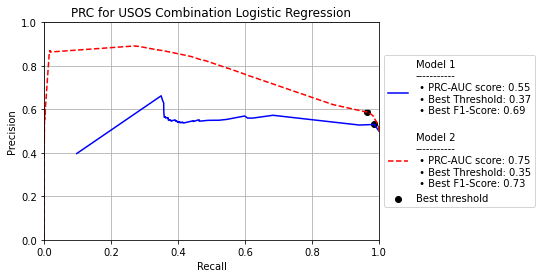

In [72]:
lr_best_threshold1, lr_best_threshold2, lr_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_test, x2_test, y2_test, lr_prediction_probs1, lr_prediction_probs2, "USOS Combination Logistic Regression")

Best Threshold=0.338895, F1-Score=0.733 for model 1
Best Threshold=0.391457, F1-Score=0.733 for model 2


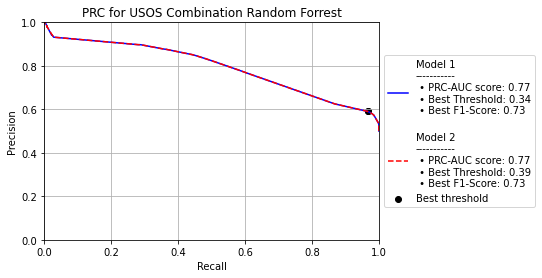

In [73]:
rf_best_threshold1, rf_best_threshold2, rf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_test, x2_test, y2_test, rf_prediction_probs1, rf_prediction_probs2, "USOS Combination Random Forrest")

Best Threshold=0.349851, F1-Score=0.733 for model 1
Best Threshold=0.369544, F1-Score=0.733 for model 2


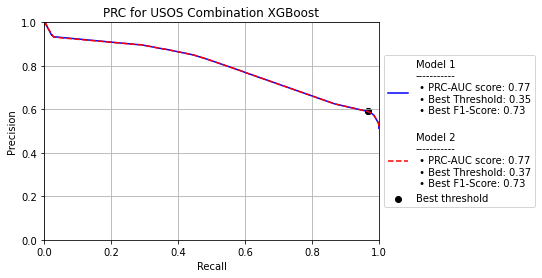

In [74]:
xgb_best_threshold1, xgb_best_threshold2, xgb_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_test, x2_test, y2_test, xgb_prediction_probs1, xgb_prediction_probs2, "USOS Combination XGBoost")

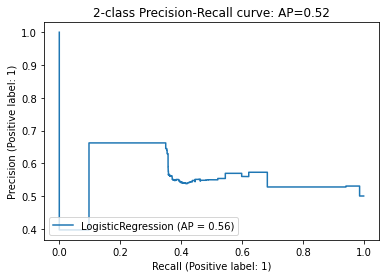

In [75]:
simple_threshold_plot(lr_model1, x1_test, y1_test)

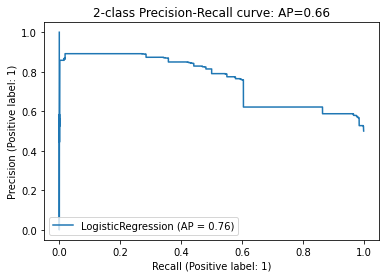

In [76]:
simple_threshold_plot(lr_model2, x2_test, y2_test)

Using the best threshold...

In [77]:
lr_prediction_bestthresh1 = (lr_model1.predict_proba(x1_test)[:,1] >= lr_best_threshold1).astype(int)
lr_prediction_bestthresh2 = (lr_model2.predict_proba(x2_test)[:,1] >= lr_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, lr_prediction_bestthresh1, lr_prediction_bestthresh2, lr_prediction_probs1, lr_prediction_probs2, lr_model1, lr_model2)
results_data[57][0] = "OSUS_Logistic_Regression_Best_Threshold"
results_data[57][1] = lr_model1.score(x1_test, y1_test)
results_data[57][2] = lr_model2.score(x2_test, y2_test)
results_data[57][3] = acc1
results_data[57][4] = acc2
results_data[57][5] = prc_val1
results_data[57][6] = prc_val2
results_data[57][7] = pr_auc1
results_data[57][8] = pr_auc2

rf_prediction_bestthresh1 = (rf_model1.predict_proba(x1_test)[:,1] >= rf_best_threshold1).astype(int)
rf_prediction_bestthresh2 = (rf_model2.predict_proba(x2_test)[:,1] >= rf_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, rf_prediction_bestthresh1, rf_prediction_bestthresh2, rf_prediction_probs1, rf_prediction_probs2, rf_model1, rf_model2)
results_data[58][0] = "OSUS_Random_Forrest_Best_Threshold"
results_data[58][1] = rf_model1.score(x1_test, y1_test)
results_data[58][2] = rf_model2.score(x2_test, y2_test)
results_data[58][3] = acc1
results_data[58][4] = acc2
results_data[58][5] = prc_val1
results_data[58][6] = prc_val2
results_data[58][7] = pr_auc1
results_data[58][8] = pr_auc2

xgb_prediction_bestthresh1 = (xgb_model1.predict_proba(x1_test)[:,1] >= xgb_best_threshold1).astype(int)
xgb_prediction_bestthresh2 = (xgb_model2.predict_proba(x2_test)[:,1] >= xgb_best_threshold2).astype(int)
acc1, acc2, prc_val1, prc_val2, pr_auc1, pr_auc2 = Compare_Model_Scores_Best_Threshold(x1_test, x2_test, y1_test, xgb_prediction_bestthresh1, xgb_prediction_bestthresh2, xgb_prediction_probs1, xgb_prediction_probs2, xgb_model1, xgb_model2)
results_data[59][0] = "OSUS_XGBoost_Classifier_Best_Threshold"
results_data[59][1] = xgb_model1.score(x1_test, y1_test)
results_data[59][2] = xgb_model2.score(x2_test, y2_test)
results_data[59][3] = acc1
results_data[59][4] = acc2
results_data[59][5] = prc_val1
results_data[59][6] = prc_val2
results_data[59][7] = pr_auc1
results_data[59][8] = pr_auc2


Scores for model 1
------------------
Roc_Auc Score: 0.5884800241160963
Average Precision-Recall Score: 0.5592218143887758
PRC-AUC for model 1: 0.5533383631970431
Accuracy: 0.557
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.13      0.22    127876
           1       0.53      0.99      0.69    127971

    accuracy                           0.56    255847
   macro avg       0.72      0.56      0.46    255847
weighted avg       0.72      0.56      0.46    255847


Scores for model 2
------------------
Roc_Auc Score: 0.7835064760337741
Average Precision-Recall Score: 0.7573865170662666
PRC-AUC for model 2: 0.7534584082827789
Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.32      0.48    127876
           1       0.59      0.96      0.73    127971

    accuracy                           0.64    255847
   macro avg       0.74      0.64      0.60    255847
weighted 

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 1

In [78]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_rkf, pr_auc, lr_rkf_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1)
results_data[60][0] = "OSUS_Combination_Logistic_Regression_rkf"
results_data[60][1] = model_score
results_data[60][3] = acc
results_data[60][5] = prc_val
results_data[60][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs1 = Rkf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[61][0] = "OSUS_Combination_Logistic_Regression_rkf_Best_Threshold"
results_data[61][1] = model_score
results_data[61][3] = acc
results_data[61][5] = prc_val
results_data[61][7] = pr_auc

Rkf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_rkf, pr_auc, rf_rkf_prediction_probs1 = Rkf(rf_model1, balanced_x1, balanced_y1)
results_data[62][0] = "OSUS_Combination_Random_Forrest_rkf"
results_data[62][1] = model_score
results_data[62][3] = acc
results_data[62][5] = prc_val
results_data[62][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs1 = Rkf(xgb_model1, balanced_x1, balanced_y1)
results_data[63][0] = "OSUS_Combination_XGB_Classifier_rkf"
results_data[63][1] = model_score
results_data[63][3] = acc
results_data[63][5] = prc_val
results_data[63][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [     8     32     42 ... 852813 852815 852817]

Model Score: 0.5391290072934499
Average Precision-Recall Score: 0.5259227950819044
PRC-AUC Score: 0.5546535935568971
Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.71      0.60     42353
           1       0.56      0.37      0.45     42929

    accuracy                           0.54     85282
   macro avg       0.55      0.54      0.53     85282
weighted avg       0.55      0.54      0.53     85282

Accuracy: 0.539
---------------------
With best threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [     8     32     42 ... 852813 852815 852817]

Model Score: 0.5391290072934499
Average Precision-Recall Score: 0.5259227950819044
PRC-AUC Score: 0.757197146015469
Classificatio

In [79]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_skf, pr_auc, lr_skf_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1)
results_data[64][0] = "OSUS_Combination_Logistic_Regression_skf"
results_data[64][1] = model_score
results_data[64][3] = acc
results_data[64][5] = prc_val
results_data[64][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs1 = Skf(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[65][0] = "OSUS_Combination_Logistic_Regression_skf_Best_Threshold"
results_data[65][1] = model_score
results_data[65][3] = acc
results_data[65][5] = prc_val
results_data[65][7] = pr_auc

Skf_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_skf, pr_auc, rf_skf_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[66][0] = "OSUS_Combination_Random_Forrest_skf"
results_data[66][1] = model_score
results_data[66][3] = acc
results_data[66][5] = prc_val
results_data[66][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_skf, pr_auc, xgb_skf_prediction_probs1 = Skf(xgb_model1, balanced_x1, balanced_y1)
results_data[67][0] = "OSUS_Combination_XGB_Classifier_skf"
results_data[67][1] = model_score
results_data[67][3] = acc
results_data[67][5] = prc_val
results_data[67][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [ 85283  85284  85285 ... 554332 554333 554334]

Model Score: 0.6861354095823269

Average Precision-Recall Score: 0.6861354095823269
PRC-AUC Score: 0.5437958772073825
Classification Report:

              precision    recall  f1-score   support

           0       0.61      1.00      0.76     42641
           1       1.00      0.37      0.54     42641

    accuracy                           0.69     85282
   macro avg       0.81      0.69      0.65     85282
weighted avg       0.81      0.69      0.65     85282

Accuracy: 0.686
---------------------
With best threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [ 85283  85284  85285 ... 554332 554333 554334]

Model Score: 0.6861354095823269

Average Precision-Recall Score: 0.6861354095823269
PRC-AUC Score: 0.7448876328799768
Classifica

In [80]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_lr_test_tss, pr_auc, lr_tss_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1)
results_data[68][0] = "OSUS_Combination_Logistic_Regression_tss"
results_data[68][1] = model_score
results_data[68][3] = acc
results_data[68][5] = prc_val
results_data[68][7] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y1_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs1 = Tss(lr_model1, balanced_x1, balanced_y1, lr_best_threshold1)
results_data[69][0] = "OSUS_Combination_Logistic_Regression_tss_Best_Threshold"
results_data[69][1] = model_score
results_data[69][3] = acc
results_data[69][5] = prc_val
results_data[69][7] = pr_auc

Tss_short(lr_model1, balanced_x1, balanced_y1)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_rf_test_tss, pr_auc, rf_tss_prediction_probs1 = Skf(rf_model1, balanced_x1, balanced_y1)
results_data[70][0] = "OSUS_Combination_Random_Forrest_tss"
results_data[70][1] = model_score
results_data[70][3] = acc
results_data[70][5] = prc_val
results_data[70][7] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y1_xgb_test_tss, pr_auc, xgb_tss_prediction_probs1 = Tss(xgb_model1, balanced_x1, balanced_y1)
results_data[71][0] = "OSUS_Combination_XGB_Classifier_tss"
results_data[71][1] = model_score
results_data[71][3] = acc
results_data[71][5] = prc_val
results_data[71][7] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 568545 568546 568547] | TEST: [568548 568549 568550 ... 710682 710683 710684]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 0.9999999999999999
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00  142137.0

    accuracy                           0.00  142137.0
   macro avg       0.00      0.00      0.00  142137.0
weighted avg       0.00      0.00      0.00  142137.0

Accuracy: 0.000
---------------------
With best threshold
TRAIN: [     0      1      2 ... 568545 568546 568547] | TEST: [568548 568549 568550 ... 710682 710683 710684]

Model Score: 0.0

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

      

##### Cross Validation After Oversampling/Undersampling Combination Rebalance for model 2

In [81]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_rkf, pr_auc, lr_rkf_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2)
results_data[60][2] = model_score
results_data[60][4] = acc
results_data[60][6] = prc_val
results_data[60][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_rkf_best, pr_auc, lr_rkf_best_prediction_probs2 = Rkf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[61][2] = model_score
results_data[61][4] = acc
results_data[61][6] = prc_val
results_data[61][8] = pr_auc

Rkf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_rkf, pr_auc, rf_rkf_prediction_probs2 = Rkf(rf_model2, balanced_x2, balanced_y2)
results_data[62][2] = model_score
results_data[62][4] = acc
results_data[62][6] = prc_val
results_data[62][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_rkf, pr_auc, xgb_rkf_prediction_probs2 = Rkf(xgb_model2, balanced_x2, balanced_y2)
results_data[63][2] = model_score
results_data[63][4] = acc
results_data[63][6] = prc_val
results_data[63][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [     8     32     42 ... 852813 852815 852817]

Model Score: 0.7077108885814123
Average Precision-Recall Score: 0.6613293709471951
PRC-AUC Score: 0.7538273657304121
Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.81      0.73     42353
           1       0.76      0.61      0.68     42929

    accuracy                           0.71     85282
   macro avg       0.72      0.71      0.71     85282
weighted avg       0.72      0.71      0.70     85282

Accuracy: 0.708
---------------------
With best threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [     8     32     42 ... 852813 852815 852817]

Model Score: 0.7077108885814123
Average Precision-Recall Score: 0.6613293709471951
PRC-AUC Score: 0.7671932525461905
Classificati

In [82]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_skf, pr_auc, lr_skf_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2)
results_data[64][2] = model_score
results_data[64][4] = acc
results_data[64][6] = prc_val
results_data[64][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_skf_best, pr_auc, lr_skf_best_prediction_probs2 = Skf(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[65][2] = model_score
results_data[65][4] = acc
results_data[65][6] = prc_val
results_data[65][8] = pr_auc

Skf_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_skf, pr_auc, rf_skf_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[66][2] = model_score
results_data[66][4] = acc
results_data[66][6] = prc_val
results_data[66][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_skf, pr_auc, xgb_skf_prediction_probs2 = Skf(xgb_model2, balanced_x2, balanced_y2)
results_data[67][2] = model_score
results_data[67][4] = acc
results_data[67][6] = prc_val
results_data[67][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [170565 170566 170567 ... 639614 639615 639616]

Model Score: 0.7989141905677635

Average Precision-Recall Score: 0.7989141905677635
PRC-AUC Score: 0.9665111043362022
Classification Report:

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     42641
           1       1.00      0.60      0.75     42641

    accuracy                           0.80     85282
   macro avg       0.86      0.80      0.79     85282
weighted avg       0.86      0.80      0.79     85282

Accuracy: 0.799
---------------------
With best threshold
TRAIN: [     0      1      2 ... 852819 852820 852821] | TEST: [170565 170566 170567 ... 639614 639615 639616]

Model Score: 0.7989141905677635

Average Precision-Recall Score: 0.7989141905677635
PRC-AUC Score: 0.9631809760559086
Classifica

In [83]:
print("--------------------------------\n|Scores for Logistic Regression|\n--------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_lr_test_tss, pr_auc, lr_tss_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2)
results_data[68][2] = model_score
results_data[68][4] = acc
results_data[68][6] = prc_val
results_data[68][8] = pr_auc
print("---------------------")
print("With best threshold")
model_score, acc, prc_val, y2_lr_test_tss_best, pr_auc, lr_tss_best_prediction_probs2 = Tss(lr_model2, balanced_x2, balanced_y2, lr_best_threshold2)
results_data[69][2] = model_score
results_data[69][4] = acc
results_data[69][6] = prc_val
results_data[69][8] = pr_auc

Tss_short(lr_model2, balanced_x2, balanced_y2)
print("--------------------------------------\n|Scores for Random Forrest Classifier|\n--------------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_rf_test_tss, pr_auc, rf_tss_prediction_probs2 = Skf(rf_model2, balanced_x2, balanced_y2)
results_data[70][2] = model_score
results_data[70][4] = acc
results_data[70][6] = prc_val
results_data[70][8] = pr_auc

print("-------------------------------\n|Scores for XGBoost Classifier|\n-------------------------------")
print("With normal threshold")
model_score, acc, prc_val, y2_xgb_test_tss, pr_auc, xgb_tss_prediction_probs2 = Tss(xgb_model2, balanced_x2, balanced_y2)
results_data[71][2] = model_score
results_data[71][4] = acc
results_data[71][6] = prc_val
results_data[71][8] = pr_auc

--------------------------------
|Scores for Logistic Regression|
--------------------------------
With normal threshold
TRAIN: [     0      1      2 ... 568545 568546 568547] | TEST: [568548 568549 568550 ... 710682 710683 710684]

Model Score: 0.34543433448011424

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.35      0.51    142137

    accuracy                           0.35    142137
   macro avg       0.50      0.17      0.26    142137
weighted avg       1.00      0.35      0.51    142137

Accuracy: 0.345
---------------------
With best threshold
TRAIN: [     0      1      2 ... 568545 568546 568547] | TEST: [568548 568549 568550 ... 710682 710683 710684]

Model Score: 0.34543433448011424

Average Precision-Recall Score: 1.0
PRC-AUC Score: 1.0
Classification Report:

              precision    recall  f1-score 

Best Threshold=0.367468, F1-Score=0.693 for model 1
Best Threshold=0.362219, F1-Score=0.733 for model 2


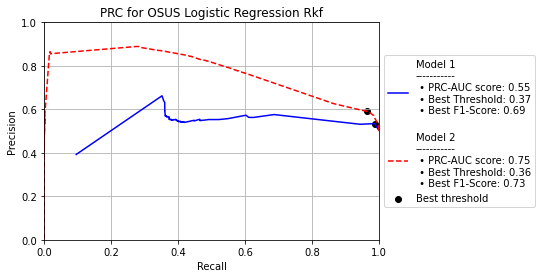

Best Threshold=0.392707, F1-Score=0.737 for model 1
Best Threshold=0.363112, F1-Score=0.737 for model 2


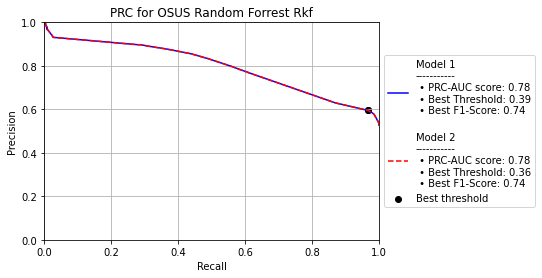

Best Threshold=0.357522, F1-Score=0.737 for model 1
Best Threshold=0.392724, F1-Score=0.737 for model 2


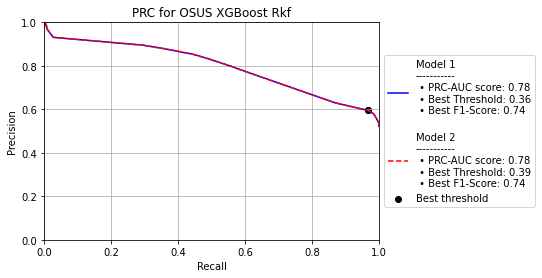

Best Threshold=0.481636, F1-Score=0.704 for model 1
Best Threshold=0.283297, F1-Score=0.983 for model 2


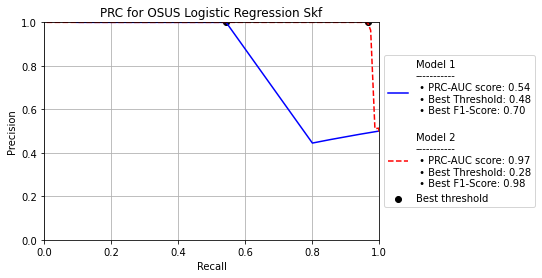

Best Threshold=0.280853, F1-Score=0.984 for model 1
Best Threshold=0.281515, F1-Score=0.984 for model 2


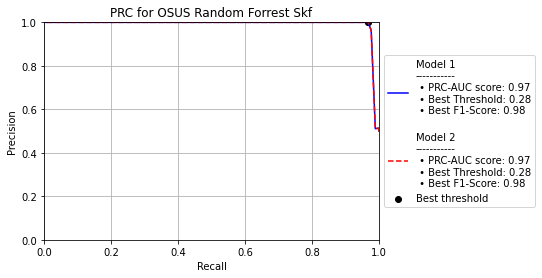

Best Threshold=0.295085, F1-Score=0.984 for model 1
Best Threshold=0.279643, F1-Score=0.984 for model 2


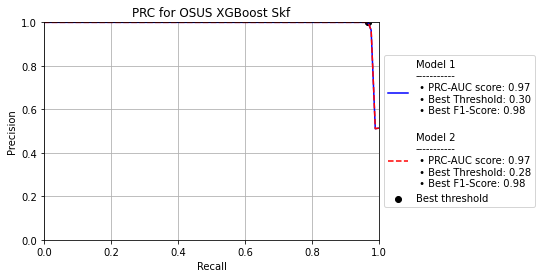

Best Threshold=0.110422, F1-Score=1.000 for model 1
Best Threshold=0.000007, F1-Score=1.000 for model 2


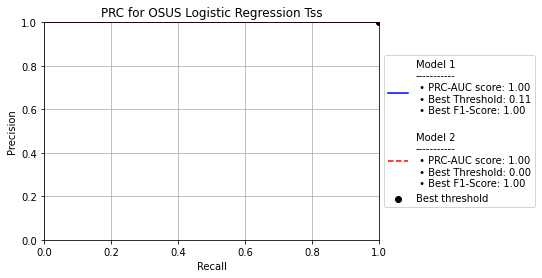

Best Threshold=0.272201, F1-Score=0.984 for model 1
Best Threshold=0.278796, F1-Score=0.984 for model 2


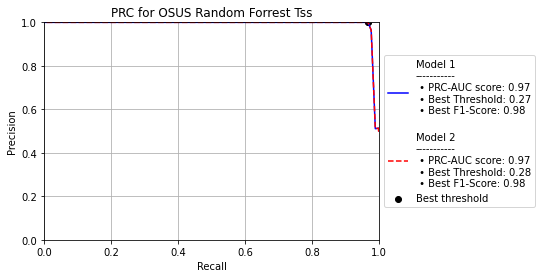

Best Threshold=0.000587, F1-Score=1.000 for model 1
Best Threshold=0.000027, F1-Score=1.000 for model 2


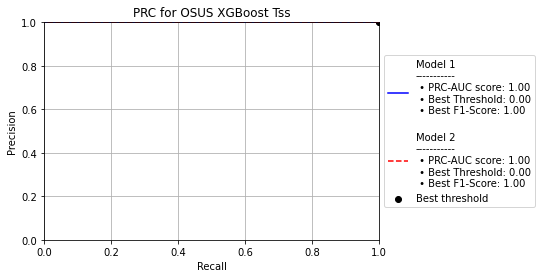

In [84]:
lr_rkf_best_threshold1, lr_rkf_best_threshold2, lr_rkf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_rkf, x2_test, y2_lr_test_rkf, lr_rkf_prediction_probs1, lr_rkf_prediction_probs2, "OSUS Logistic Regression Rkf")
rf_rkf_best_threshold1, rf_rkf_best_threshold2, rf_rkf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_rkf, x2_test, y2_rf_test_rkf, rf_rkf_prediction_probs1, rf_rkf_prediction_probs2, "OSUS Random Forrest Rkf")
xgb_rkf_best_threshold1, xgb_rkf_best_threshold2, xgb_rkf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_rkf, x2_test, y2_xgb_test_rkf, xgb_rkf_prediction_probs1, xgb_rkf_prediction_probs2, "OSUS XGBoost Rkf")

lr_skf_best_threshold1, lr_skf_best_threshold2, lr_skf_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_skf, x2_test, y2_lr_test_skf, lr_skf_prediction_probs1, lr_skf_prediction_probs2, "OSUS Logistic Regression Skf")
rf_skf_best_threshold1, rf_skf_best_threshold2, rf_skf_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_skf, x2_test, y2_rf_test_skf, rf_skf_prediction_probs1, rf_skf_prediction_probs2, "OSUS Random Forrest Skf")
xgb_skf_best_threshold1, xgb_skf_best_threshold2, xgb_skf_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_skf, x2_test, y2_xgb_test_skf, xgb_skf_prediction_probs1, xgb_skf_prediction_probs2, "OSUS XGBoost Skf")

lr_tss_best_threshold1, lr_tss_best_threshold2, lr_tss_osus_fig = plot_thresholds(lr_model1, lr_model2, x1_test, y1_lr_test_tss, x2_test, y2_lr_test_tss, lr_tss_prediction_probs1, lr_tss_prediction_probs2, "OSUS Logistic Regression Tss")
rf_tss_best_threshold1, rf_tss_best_threshold2, rf_tss_osus_fig = plot_thresholds(rf_model1, rf_model2, x1_test, y1_rf_test_tss, x2_test, y2_rf_test_tss, rf_tss_prediction_probs1, rf_tss_prediction_probs2, "OSUS Random Forrest Tss")
xgb_tss_best_threshold1, xgb_tss_best_threshold2, xgb_tss_osus_fig = plot_thresholds(xgb_model1, xgb_model2, x1_test, y1_xgb_test_tss, x2_test, y2_xgb_test_tss, xgb_tss_prediction_probs1, xgb_tss_prediction_probs2, "OSUS XGBoost Tss")

In [85]:
results_df = pd.DataFrame(results_data, columns = ['Test', 'Model1 score', 'Model2 score', 'Model1 accuracy', 'Model2 accuracy', 'Model1 avg. PR score', 'Model2 avg. PR score', 'Model1 PRC-AUC Score', 'Model2 PRC-AUC Score'])
model1_results_df = results_df[['Test', 'Model1 score', 'Model1 accuracy', 'Model1 avg. PR score', 'Model1 PRC-AUC Score']]
model2_results_df = results_df[['Test', 'Model2 score', 'Model2 accuracy', 'Model2 avg. PR score', 'Model2 PRC-AUC Score']]

In [86]:
results_df

,Test,Model1 score,Model2 score,Model1 accuracy,Model2 accuracy,Model1 avg. PR score,Model2 avg. PR score,Model1 PRC-AUC Score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.826525,0.846818,0.826525,0.846818,0.193928,0.436738,0.184615,0.457121
1,Original_Random_Forrest,0.849114,0.849127,0.849114,0.849127,0.456332,0.456396,0.492203,0.492486
2,Original_XGB_Classifier,0.849140,0.849127,0.849140,0.849127,0.456177,0.456341,0.493367,0.492596
3,Original_Logistic_Regression_Best_Threshold,0.826525,0.846818,0.627861,0.803127,0.193928,0.436738,0.102304,0.310644
4,Original_Random_Forrest_Best_Threshold,0.849114,0.849127,0.821274,0.821274,0.456332,0.456396,0.331701,0.332019
...,...,...,...,...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.804273,0.804296,0.804273,0.804296,0.804273,0.804296,0.967942,0.967989
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.345434,0.000000,0.345434,1.000000,1.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.345434,0.000000,0.345434,1.000000,1.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.804343,0.804343,0.804343,0.804343,0.804343,0.804343,0.968059,0.968059


In [87]:
model1_results_df

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
0,Original_Logistic_Regression,0.826525,0.826525,0.193928,0.184615
1,Original_Random_Forrest,0.849114,0.849114,0.456332,0.492203
2,Original_XGB_Classifier,0.849140,0.849140,0.456177,0.493367
3,Original_Logistic_Regression_Best_Threshold,0.826525,0.627861,0.193928,0.102304
4,Original_Random_Forrest_Best_Threshold,0.849114,0.821274,0.456332,0.331701
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.804273,0.804273,0.804273,0.967942
68,OSUS_Combination_Logistic_Regression_tss,0.000000,0.000000,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.000000,0.000000,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.804343,0.804343,0.804343,0.968059


In [88]:
model2_results_df

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
0,Original_Logistic_Regression,0.846818,0.846818,0.436738,0.457121
1,Original_Random_Forrest,0.849127,0.849127,0.456396,0.492486
2,Original_XGB_Classifier,0.849127,0.849127,0.456341,0.492596
3,Original_Logistic_Regression_Best_Threshold,0.846818,0.803127,0.436738,0.310644
4,Original_Random_Forrest_Best_Threshold,0.849127,0.821274,0.456396,0.332019
...,...,...,...,...,...
67,OSUS_Combination_XGB_Classifier_skf,0.804296,0.804296,0.804296,0.967989
68,OSUS_Combination_Logistic_Regression_tss,0.345434,0.345434,1.000000,1.000000
69,OSUS_Combination_Logistic_Regression_tss_Best_...,0.345434,0.345434,1.000000,1.000000
70,OSUS_Combination_Random_Forrest_tss,0.804343,0.804343,0.804343,0.968059


In [89]:
model1_results_df[~model1_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model1 PRC-AUC Score', 'Model1 score'], ascending=False)

,Test,Model1 score,Model1 accuracy,Model1 avg. PR score,Model1 PRC-AUC Score
12,Original_Random_Forrest_skf,1.000000,1.000000,1.000000,1.000000
13,Original_XGB_Classifier_skf,1.000000,1.000000,1.000000,1.000000
66,OSUS_Combination_Random_Forrest_skf,0.804343,0.804343,0.804343,0.968059
67,OSUS_Combination_XGB_Classifier_skf,0.804273,0.804273,0.804273,0.967942
49,Oversampled_XGB_Classifier_skf,0.803663,0.803663,0.803663,0.892147
48,Oversampled_Random_Forrest_skf,0.803675,0.803675,0.803675,0.888628
56,OSUS_Combination_XGB_Classifier,0.710698,0.710698,0.767073,0.793951
55,OSUS_Combination_Random_Forrest,0.710726,0.710726,0.767095,0.793709
38,Oversampled_XGB_Classifier,0.709037,0.709037,0.764786,0.791949
37,Oversampled_Random_Forrest,0.708892,0.708892,0.764795,0.791871


In [90]:
model2_results_df[~model2_results_df.Test.str.contains("tss", na=False)].sort_values(by=['Model2 PRC-AUC Score'], ascending=False)

,Test,Model2 score,Model2 accuracy,Model2 avg. PR score,Model2 PRC-AUC Score
13,Original_XGB_Classifier_skf,1.000000,1.000000,1.000000,1.000000
10,Original_Logistic_Regression_skf,1.000000,1.000000,1.000000,1.000000
12,Original_Random_Forrest_skf,1.000000,1.000000,1.000000,1.000000
11,Original_Logistic_Regression_skf_Best_Threshold,1.000000,1.000000,1.000000,1.000000
66,OSUS_Combination_Random_Forrest_skf,0.804332,0.804332,0.804332,0.968059
67,OSUS_Combination_XGB_Classifier_skf,0.804296,0.804296,0.804296,0.967989
64,OSUS_Combination_Logistic_Regression_skf,0.798914,0.798914,0.798914,0.966511
65,OSUS_Combination_Logistic_Regression_skf_Best_...,0.798914,0.798914,0.798914,0.963181
49,Oversampled_XGB_Classifier_skf,0.803663,0.803663,0.803663,0.892147
46,Oversampled_Logistic_Regression_skf,0.799641,0.799641,0.799641,0.888278


In [93]:
figures = [lr_skf_osus_fig, rf_skf_osus_fig, xgb_skf_osus_fig]

for i, figure in enumerate(figures):
    figure.savefig(f"../../img/Camel/graphs/Precision vs. Recall Results/Figure_{i}", dpi=300, bbox_inches='tight')

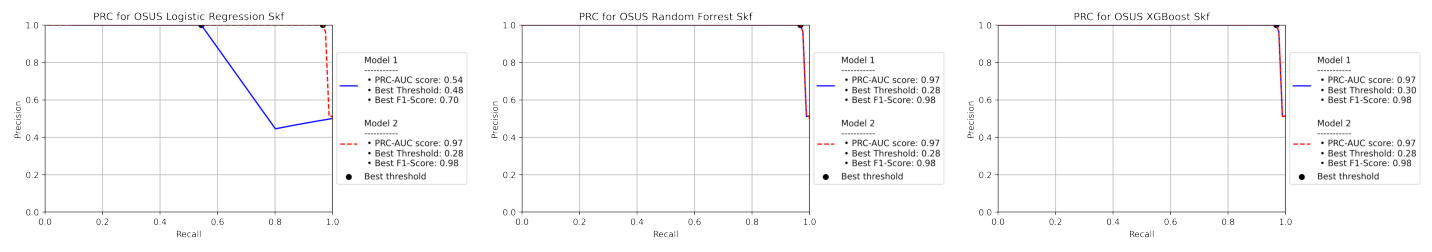

In [94]:
img_A = mpimg.imread('../../img/Camel/graphs/Precision vs. Recall Results/Figure_0.png')
img_B = mpimg.imread('../../img/Camel/graphs/Precision vs. Recall Results/Figure_1.png')
img_C = mpimg.imread('../../img/Camel/graphs/Precision vs. Recall Results/Figure_2.png')
# display images
fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(img_A);
ax[0].axis('off')
ax[1].imshow(img_B);
ax[1].axis('off')
ax[2].imshow(img_C);
ax[2].axis('off')
fig.tight_layout()
fig.savefig(f"../../img/Camel/graphs/Precision vs. Recall Results/Figure_final.png", dpi=300, bbox_inches='tight')